In [1]:
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import os
import glob
import torch
import torch.nn as nn
import freetype
import uharfbuzz as hb
import cv2
from collections import Counter

In [2]:
# Load the NepaliText dataset
dataset = load_dataset("Sakonii/nepalitext-language-model-dataset")
train_texts = dataset["train"]["text"]
print(f"Loaded dataset with {len(train_texts)} training samples")

Loaded dataset with 13141222 training samples


In [3]:
import random
import re

# -----------------------------------------
# Extract Nepali words
# -----------------------------------------
def extract_nepali_words(text):
    """Extract Devanagari words from text."""
    if not isinstance(text, str):
        return []
    matches = re.findall(r"[\u0900-\u097F]+", text)
    return [w for w in matches if 2 <= len(w) <= 30]

all_words = set()
print("Extracting Nepali words from dataset...")

for i, text in enumerate(train_texts):
    words = extract_nepali_words(text)
    all_words.update(words)

    if (i + 1) % 10000 == 0:
        print(f"  Processed {i + 1} texts, found {len(all_words)} unique words")

# -----------------------------------------
# Shuffle and sample 5000 words
# -----------------------------------------
all_words = list(all_words)
random.shuffle(all_words)

training_pool = all_words[:5000]     # Use exactly 5000 for splitting
print(f"\n✓ Total unique words: {len(all_words)}")
print(f"✓ Using {len(training_pool)} words for OCR dataset")

# -----------------------------------------
# Create train/val/test split
# -----------------------------------------
random.seed(42)  # for reproducibility
random.shuffle(training_pool)

total = len(training_pool)
val_size = int(total * 0.1)
test_size = int(total * 0.1)
train_size = total - val_size - test_size

train_words = training_pool[:train_size]
val_words   = training_pool[train_size:train_size + val_size]
test_words  = training_pool[train_size + val_size:]

print("\n===== SPLIT SUMMARY =====")
print(f"Train: {len(train_words)} words")
print(f"Val  : {len(val_words)} words")
print(f"Test : {len(test_words)} words")
print("\nSample words (train):", train_words[:10])


Extracting Nepali words from dataset...
  Processed 10000 texts, found 49361 unique words
  Processed 20000 texts, found 77417 unique words
  Processed 30000 texts, found 100764 unique words
  Processed 40000 texts, found 119936 unique words
  Processed 50000 texts, found 137609 unique words
  Processed 60000 texts, found 153427 unique words
  Processed 70000 texts, found 167843 unique words
  Processed 80000 texts, found 182163 unique words
  Processed 90000 texts, found 195560 unique words
  Processed 100000 texts, found 208380 unique words
  Processed 110000 texts, found 220954 unique words
  Processed 120000 texts, found 232162 unique words
  Processed 130000 texts, found 243317 unique words
  Processed 140000 texts, found 254115 unique words
  Processed 150000 texts, found 264583 unique words
  Processed 160000 texts, found 274815 unique words
  Processed 170000 texts, found 285196 unique words
  Processed 180000 texts, found 294661 unique words
  Processed 190000 texts, found 305

In [4]:
from PIL import ImageFilter


class SyntheticHarfBuzzOCRDatasetGenerator:
    """Generate synthetic OCR dataset with HarfBuzz shaping."""

    def __init__(
        self,
        strings,
        fonts_dir="fonts",
        output_dir="data/word_images",
        font_size_range=(40, 56),
        random_blur=True,
        random_noise=True,
        random_rotate=True,
        random_distortion=True,
        background_mode="random",
        max_image_size=1024
    ):
        self.strings = strings
        self.fonts = glob.glob(os.path.join(fonts_dir, "**/*.ttf"), recursive=True)
        if not self.fonts:
            raise ValueError(f"No fonts found in {fonts_dir}")

        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

        self.font_size_range = font_size_range
        self.random_blur = random_blur
        self.random_noise = random_noise
        self.random_rotate = random_rotate
        self.random_distortion = random_distortion
        self.background_mode = background_mode
        self.MAX_SIZE = max_image_size

    def _clamp_image_size(self, img):
        w, h = img.size
        if w > self.MAX_SIZE or h > self.MAX_SIZE:
            img.thumbnail((self.MAX_SIZE, self.MAX_SIZE), Image.LANCZOS)
        return img

    def generate_dataset(self):
        for idx, text in enumerate(self.strings, start=1):
            img = self.render_text_image(text)
            image_path = os.path.join(self.output_dir, f"{idx:05d}.png")
            label_path = os.path.join(self.output_dir, f"{idx:05d}.txt")
            img.save(image_path)
            with open(label_path, "w", encoding="utf-8") as f:
                f.write(text)
            if idx % 500 == 0:
                print(f"  [{idx}/{len(self.strings)}] Generated images")

    def render_text_image(self, text, padding=20):
        font_path = random.choice(self.fonts)
        font_size = random.randint(*self.font_size_range)
        face = freetype.Face(font_path)
        face.set_char_size(font_size * 64)

        # HarfBuzz shaping
        hb_blob = hb.Blob.from_file_path(font_path)
        hb_face = hb.Face(hb_blob, 0)
        hb_font = hb.Font(hb_face)
        hb_font.scale = (face.size.ascender, face.size.ascender)

        buf = hb.Buffer()
        buf.add_str(text)
        buf.guess_segment_properties()
        hb.shape(hb_font, buf)

        infos = buf.glyph_infos
        positions = buf.glyph_positions

        width = sum(pos.x_advance for pos in positions) // 64 + 2*padding
        height = font_size + 2*padding

        if self.background_mode == "white":
            img = Image.new("RGB", (width, height), "white")
        elif self.background_mode == "lightgray":
            img = Image.new("RGB", (width, height), "lightgray")
        else:
            arr = np.random.randint(200, 255, (height, width, 3), dtype=np.uint8)
            img = Image.fromarray(arr)

        x, y = padding, padding + font_size

        for info, pos in zip(infos, positions):
            glyph_index = info.codepoint
            face.load_glyph(glyph_index, freetype.FT_LOAD_RENDER)
            bitmap = face.glyph.bitmap
            top = face.glyph.bitmap_top
            left = face.glyph.bitmap_left

            if bitmap.width > 0 and bitmap.rows > 0:
                glyph_img = Image.frombytes("L", (bitmap.width, bitmap.rows), bytes(bitmap.buffer))
                colored_glyph = Image.new("RGB", glyph_img.size, "black")
                img.paste(colored_glyph, (int(x + left), int(y - top)), glyph_img)

            x += pos.x_advance / 64
            y -= pos.y_advance / 64

        img = self._clamp_image_size(img)

        # --- FIXED BLUR SECTION ---
        from PIL import ImageFilter

        if self.random_blur and random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))


        if self.random_rotate:
            angle = random.randint(-7, 7)
            img = img.rotate(angle, expand=True, fillcolor="white")
            img = self._clamp_image_size(img)

        if self.random_distortion:
            img = self.perspective_distortion(img)

        if self.random_noise:
            img = self.add_noise(img)

        return img

    def perspective_distortion(self, img):
        img = self._clamp_image_size(img)
        w, h = img.size
        arr = np.array(img)
        shift = min(w, h) * 0.1

        pts1 = np.float32([[0,0],[w,0],[0,h],[w,h]])
        pts2 = np.float32([
            [random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
        ])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped = cv2.warpPerspective(arr, matrix, (w,h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))
        return Image.fromarray(warped)

    def add_noise(self, img):
        arr = np.array(img).astype(np.float32)
        if random.random() < 0.5:
            arr += np.random.normal(0, 10, arr.shape)
        if random.random() < 0.5:
            amount = 0.02
            num_salt = int(arr.size * amount * 0.5)
            num_pepper = int(arr.size * amount * 0.5)
            coords = [np.random.randint(0, i - 1, num_salt) for i in arr.shape]
            arr[tuple(coords)] = 255
            coords = [np.random.randint(0, i - 1, num_pepper) for i in arr.shape]
            arr[tuple(coords)] = 0
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8))

In [6]:
import os
# from synthetic_generator import SyntheticHarfBuzzOCRDatasetGenerator  # your class

def generate_split(words, out_dir):
    """Use your existing generator to create a split."""
    print(f"\n=== Generating split: {out_dir} ===")

    os.makedirs(out_dir, exist_ok=True)

    generator = SyntheticHarfBuzzOCRDatasetGenerator(
        strings=words,
        fonts_dir="fonts",
        output_dir=out_dir,
        font_size_range=(40, 56),
        random_blur=True,
        random_noise=True,
        random_rotate=True,
        random_distortion=True,
        background_mode="random",
        max_image_size=1024
    )

    generator.generate_dataset()

    print(f"✓ Completed: {out_dir}")


# ============================================================
#              MAIN – GENERATE DATASET SPLITS
# ============================================================

root = "data/ocr_dataset"

train_dir = os.path.join(root, "train")
val_dir   = os.path.join(root, "val")
test_dir  = os.path.join(root, "test")

os.makedirs(root, exist_ok=True)

# --- Generate all ---
generate_split(train_words, train_dir)
generate_split(val_words, val_dir)
generate_split(test_words, test_dir)

print("\n==============================")
print("✓ OCR DATASET GENERATION DONE")
print("==============================")



=== Generating split: data/ocr_dataset/train ===
  [500/4000] Generated images
  [1000/4000] Generated images
  [1500/4000] Generated images
  [2000/4000] Generated images
  [2500/4000] Generated images
  [3000/4000] Generated images
  [3500/4000] Generated images
  [4000/4000] Generated images
✓ Completed: data/ocr_dataset/train

=== Generating split: data/ocr_dataset/val ===
  [500/500] Generated images
✓ Completed: data/ocr_dataset/val

=== Generating split: data/ocr_dataset/test ===
  [500/500] Generated images
✓ Completed: data/ocr_dataset/test

✓ OCR DATASET GENERATION DONE


In [7]:
# ===========================================
#      BUILD CHARSET FROM ALL SPLITS
# ===========================================

all_dataset_words = list(train_words) + list(val_words) + list(test_words)

# Extract unique characters
charset = set()
for word in all_dataset_words:
    charset.update(word)

charset = sorted(list(charset))

# Save to file
os.makedirs("data", exist_ok=True)
charset_path = "data/charset.txt"

with open(charset_path, "w", encoding="utf-8") as f:
    f.write("".join(charset))

print("=" * 70)
print("CHARSET GENERATION COMPLETE")
print("=" * 70)
print(f"✓ Total characters: {len(charset)}")
print(f"✓ Charset saved to: {charset_path}")
print(f"✓ num_classes = {len(charset) + 1} (includes CTC Blank)")
print("Sample characters:", charset[:20])


CHARSET GENERATION COMPLETE
✓ Total characters: 77
✓ Charset saved to: data/charset.txt
✓ num_classes = 78 (includes CTC Blank)
Sample characters: ['ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च']


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

# -------------------------------
# Pretrained ResNet-18 Feature Extractor
# -------------------------------
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, img_channels=1):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        
        # Modify first conv layer if input is grayscale (1 channel)
        if img_channels != 3:
            self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = resnet.conv1
        
        # Copy remaining layers (exclude avgpool and fc)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # Adaptive pooling to height=1
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.adaptive_pool(x)  # [B, C, 1, W]
        x = x.squeeze(2)           # [B, C, W]
        x = x.permute(2, 0, 1)     # [W, B, C] for BiLSTM
        return x

# -------------------------------
# BiLSTM for CRNN
# -------------------------------
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return self.embedding(recurrent)

# -------------------------------
# OCR Model with Pretrained ResNet18 + BiLSTM
# -------------------------------
class OCRModelResNet18(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256, pretrained=True):
        super().__init__()
        self.cnn = ResNet18Backbone(pretrained=pretrained, img_channels=img_channels)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        features = self.cnn(x)
        return self.rnn(features)

    def compute_ctc_loss(self, preds, targets, pred_lengths, target_lengths):
        preds_log = preds.log_softmax(2)
        return self.ctc_loss(preds_log, targets, pred_lengths, target_lengths)

print("✓ Pretrained ResNet-18 CRNN defined (with BiLSTM + CTC)")


✓ Pretrained ResNet-18 CRNN defined (with BiLSTM + CTC)


In [9]:
import subprocess
import sys

# Create config
config_content = f"""# CRNN OCR Configuration
num_classes: {len(charset) + 1}
num_channels: 1
hidden_size: 256

img_height: 32
img_width: 256

batch_size: 32
epochs: 100
learning_rate: 0.001
weight_decay: 1e-5
scheduler_step: 15
scheduler_gamma: 0.5

train_samples: 5000
samples_per_word: 1
fonts_dir: "fonts"
output_dir: "data/word_images"
charset_path: "charset.txt"
"""

with open("config.yaml", "w") as f:
    f.write(config_content)

print("✓ config.yaml created")
print(f"✓ Charset size: {len(charset)} → {len(charset) + 1} classes")
print("\nTo start training, run: python scripts/train_word_ocr.py")

✓ config.yaml created
✓ Charset size: 77 → 78 classes

To start training, run: python scripts/train_word_ocr.py


In [10]:
import yaml

with open("config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

print("Loaded config:", cfg)


Loaded config: {'num_classes': 78, 'num_channels': 1, 'hidden_size': 256, 'img_height': 32, 'img_width': 256, 'batch_size': 32, 'epochs': 100, 'learning_rate': 0.001, 'weight_decay': '1e-5', 'scheduler_step': 15, 'scheduler_gamma': 0.5, 'train_samples': 5000, 'samples_per_word': 1, 'fonts_dir': 'fonts', 'output_dir': 'data/word_images', 'charset_path': 'charset.txt'}


In [11]:
with open("config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

# FIX the incorrect type
cfg["weight_decay"] = float(cfg["weight_decay"])


In [15]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

# ===============================
# OCR Dataset for Nepali CRNN
# ===============================
class OCRDataset(Dataset):
    def __init__(self, root, charset_path, img_h=32, img_w=256, debug=False):
        """
        root: path to train/val/test folder
        charset_path: path to charset.txt
        img_h, img_w: target image size
        debug: print info for each sample
        """
        self.root = root
        self.img_h = img_h
        self.img_w = img_w
        self.debug = debug

        # Load all image files
        self.files = sorted([f for f in os.listdir(root) if f.endswith(".png")])

        # Load charset
        with open(charset_path, "r", encoding="utf-8") as f:
            self.charset = ["blank"] + list(f.read().strip())
        self.char_to_idx = {c: i for i, c in enumerate(self.charset)}

    def encode(self, text):
        indices = [self.char_to_idx[c] for c in text if c in self.char_to_idx]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)
        txt_path = os.path.join(self.root, img_name[:-4] + ".txt")

        # Load and resize image (height fixed, width scaled)
        img = Image.open(img_path).convert("L")
        w, h = img.size
        new_h = self.img_h
        new_w = int(w * (new_h / h))
        img = img.resize((new_w, new_h), Image.LANCZOS)

        # Pad width to img_w if needed
        if new_w < self.img_w:
            padded = Image.new("L", (self.img_w, new_h), 255)
            padded.paste(img, (0, 0))
            img = padded
        else:
            img = img.crop((0, 0, self.img_w, new_h))  # crop if wider than img_w

        img = np.array(img)
        img = torch.from_numpy(img).float().unsqueeze(0) / 255.0  # [1,H,W]

        # Load label
        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        label = self.encode(text)

        if self.debug:
            print(f"[{idx}] {img_name}: text='{text}', label={label}, len={len(label)}")

        return img, label

# ===============================
# Collate function for DataLoader
# ===============================
def ocr_collate(batch):
    imgs, labels, label_lens = [], [], []

    for img, label in batch:
        if len(label) == 0:
            continue
        imgs.append(img)
        labels.append(label)
        label_lens.append(len(label))

    if len(imgs) == 0:
        raise ValueError("All labels in this batch are empty. Check charset or txt files.")

    imgs = torch.stack(imgs)
    labels = torch.cat(labels)
    label_lens = torch.tensor(label_lens, dtype=torch.int32)

    return imgs, labels, label_lens


In [16]:
import torch
from torch.utils.data import DataLoader

# ===============================
# Paths and Parameters
# ===============================
train_root = "data/ocr_dataset/train"
val_root   = "data/ocr_dataset/val"
test_root  = "data/ocr_dataset/test"

charset_path = "data/charset.txt"

img_h = 32
img_w = 256
batch_size = 32
num_workers = 4  # adjust based on your CPU

# ===============================
# Create Datasets
# ===============================
train_dataset = OCRDataset(train_root, charset_path, img_h=img_h, img_w=img_w, debug=False)
val_dataset   = OCRDataset(val_root, charset_path, img_h=img_h, img_w=img_w, debug=False)
test_dataset  = OCRDataset(test_root, charset_path, img_h=img_h, img_w=img_w, debug=False)

# ===============================
# Create DataLoaders
# ===============================
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ocr_collate,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=ocr_collate,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=ocr_collate,
    num_workers=num_workers,
    pin_memory=True
)

# ===============================
# Verification
# ===============================
if __name__ == "__main__":
    batch = next(iter(train_loader))
    imgs, labels, label_lens = batch
    print(f"Images: {imgs.shape} [B,C,H,W]")
    print(f"Labels length: {label_lens}")
    print(f"Total labels: {labels.shape}")


Images: torch.Size([32, 1, 32, 256]) [B,C,H,W]
Labels length: tensor([10, 11,  5, 11, 10, 13,  6, 18, 13, 11, 11,  7, 10, 13, 11, 12,  9,  8,
        12, 12,  7,  5,  7, 10,  4,  8, 10,  7, 14, 10,  6,  7],
       dtype=torch.int32)
Total labels: torch.Size([308])


In [17]:
import os
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
from dataset import OCRDataset, ocr_collate  # your dataset code
from crnn_model import OCRModelResNet18     # your CRNN model code

# ===============================
# Load config
# ===============================
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# Paths
# ===============================
train_root = os.path.join(cfg["output_dir"], "train")
val_root   = os.path.join(cfg["output_dir"], "val")
test_root  = os.path.join(cfg["output_dir"], "test")
charset_path = cfg["charset_path"]

# ===============================
# Datasets & DataLoaders
# ===============================
train_dataset = OCRDataset(train_root, charset_path, img_h=cfg["img_height"], img_w=cfg["img_width"])
val_dataset   = OCRDataset(val_root, charset_path, img_h=cfg["img_height"], img_w=cfg["img_width"])
test_dataset  = OCRDataset(test_root, charset_path, img_h=cfg["img_height"], img_w=cfg["img_width"])

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=cfg["batch_size"], shuffle=False,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)

# ===============================
# Model, optimizer, scheduler
# ===============================
model = OCRModelResNet18(num_classes=cfg["num_classes"], img_channels=cfg["num_channels"],
                         hidden_size=cfg["hidden_size"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=cfg["learning_rate"], weight_decay=cfg["weight_decay"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg["scheduler_step"], gamma=cfg["scheduler_gamma"])

# ===============================
# Training loop
# ===============================
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(1, cfg["epochs"] + 1):
    model.train()
    running_loss = 0.0

    for imgs, labels, label_lens in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg['epochs']}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        preds = model(imgs)

        batch_size = imgs.size(0)
        pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long).to(device)

        loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch}/{cfg['epochs']}] → Average Loss: {avg_loss:.4f}")

    # Save sample image from validation set
    model.eval()
    sample_img, sample_label = next(iter(val_loader))
    sample_img = sample_img.to(device)
    with torch.no_grad():
        pred = model(sample_img)
        pred_text_idx = pred.argmax(2)[:, 0].cpu().numpy()  # greedy decode
        pred_text = "".join([train_dataset.charset[i] for i in pred_text_idx if i != 0])

    save_path = os.path.join(checkpoint_dir, f"epoch_{epoch}_sample.png")
    save_image(sample_img[0], save_path)
    print(f"Sample prediction saved: {save_path} → Predicted text: {pred_text}")

    # Save checkpoint
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"crnn_epoch_{epoch}.pth"))
    scheduler.step()

print("✓ Training complete")


ModuleNotFoundError: No module named 'dataset'

In [22]:
import yaml

with open("config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

print("Loaded config:", cfg)


Loaded config: {'num_classes': 79, 'num_channels': 1, 'hidden_size': 256, 'img_height': 32, 'img_width': 256, 'batch_size': 64, 'epochs': 100, 'learning_rate': 0.001, 'weight_decay': '1e-5', 'scheduler_step': 15, 'scheduler_gamma': 0.5, 'train_samples': 5000, 'samples_per_word': 1, 'fonts_dir': 'fonts', 'output_dir': 'data/ocr_dataset', 'charset_path': 'charset.txt'}


In [23]:
with open("config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

# FIX the incorrect type
cfg["weight_decay"] = float(cfg["weight_decay"])


In [25]:
import os
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from tqdm import tqdm
import torchvision.models as models

# ===============================
# -------------------------------
# OCR Dataset
# -------------------------------
# ===============================
class OCRDataset(Dataset):
    def __init__(self, root, charset_path, img_h=32, img_w=256, debug=False):
        self.root = root
        self.img_h = img_h
        self.img_w = img_w
        self.debug = debug

        self.files = sorted([f for f in os.listdir(root) if f.endswith(".png")])

        with open(charset_path, "r", encoding="utf-8") as f:
            self.charset = ["blank"] + list(f.read().strip())
        self.char_to_idx = {c: i for i, c in enumerate(self.charset)}

    def encode(self, text):
        indices = [self.char_to_idx[c] for c in text if c in self.char_to_idx]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)
        txt_path = os.path.join(self.root, img_name[:-4] + ".txt")

        img = Image.open(img_path).convert("L")
        w, h = img.size
        new_h = self.img_h
        new_w = int(w * (new_h / h))
        img = img.resize((new_w, new_h), Image.LANCZOS)

        # pad width
        if new_w < self.img_w:
            padded = Image.new("L", (self.img_w, new_h), 255)
            padded.paste(img, (0, 0))
            img = padded
        else:
            img = img.crop((0, 0, self.img_w, new_h))

        img = np.array(img)
        img = torch.from_numpy(img).float().unsqueeze(0) / 255.0

        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        label = self.encode(text)

        if self.debug:
            print(f"[{idx}] {img_name}: text='{text}', label={label}, len={len(label)}")

        return img, label


def ocr_collate(batch):
    imgs, labels, label_lens = [], [], []
    for img, label in batch:
        if len(label) == 0:
            continue
        imgs.append(img)
        labels.append(label)
        label_lens.append(len(label))

    if len(imgs) == 0:
        raise ValueError("All labels in this batch are empty.")

    imgs = torch.stack(imgs)
    labels = torch.cat(labels)
    label_lens = torch.tensor(label_lens, dtype=torch.int32)
    return imgs, labels, label_lens

# ===============================
# -------------------------------
# CRNN Model with pretrained ResNet-18
# -------------------------------
# ===============================
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, img_channels=1):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        if img_channels != 3:
            self.conv1 = nn.Conv2d(img_channels, 64, 7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = resnet.conv1

        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)
        return x


class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return self.embedding(recurrent)


class OCRModelResNet18(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256, pretrained=True):
        super().__init__()
        self.cnn = ResNet18Backbone(pretrained=pretrained, img_channels=img_channels)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        features = self.cnn(x)
        return self.rnn(features)

    def compute_ctc_loss(self, preds, targets, pred_lengths, target_lengths):
        preds_log = preds.log_softmax(2)
        return self.ctc_loss(preds_log, targets, pred_lengths, target_lengths)

# ===============================
# -------------------------------
# Load Config
# ------------------------------
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# Use GPU 2
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# Prepare DataLoaders
# ===============================
train_dataset = OCRDataset(os.path.join(cfg["output_dir"], "train"), cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])
val_dataset   = OCRDataset(os.path.join(cfg["output_dir"], "val"), cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])
test_dataset  = OCRDataset(os.path.join(cfg["output_dir"], "test"), cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=cfg["batch_size"], shuffle=False,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)

# ===============================
# Initialize model, optimizer, scheduler
# ===============================
model = OCRModelResNet18(num_classes=cfg["num_classes"], img_channels=cfg["num_channels"],
                         hidden_size=cfg["hidden_size"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg["learning_rate"], weight_decay=cfg["weight_decay"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg["scheduler_step"], gamma=cfg["scheduler_gamma"])

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ===============================
# Training loop
# ===============================
for epoch in range(1, cfg["epochs"] + 1):
    model.train()
    running_loss = 0.0

    for imgs, labels, label_lens in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg['epochs']}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(imgs)

        batch_size = imgs.size(0)
        pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long).to(device)

        loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch}/{cfg['epochs']}] → Average Loss: {avg_loss:.4f}")

    # Save sample image from validation
    model.eval()
    sample_img, _ = next(iter(val_loader))
    sample_img = sample_img.to(device)
    with torch.no_grad():
        pred = model(sample_img)
        pred_text_idx = pred.argmax(2)[:,0].cpu().numpy()
        pred_text = "".join([train_dataset.charset[i] for i in pred_text_idx if i != 0])

    save_path = os.path.join(checkpoint_dir, f"epoch_{epoch}_sample.png")
    save_image(sample_img[0], save_path)
    print(f"Sample prediction saved: {save_path} → Predicted text: {pred_text}")

    # Save checkpoint
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"crnn_epoch_{epoch}.pth"))
    scheduler.step()

print("✓ Training complete")


Using device: cuda


Epoch 1/100: 100%|██████████| 63/63 [00:05<00:00, 11.38it/s]


Epoch [1/100] → Average Loss: nan


ValueError: too many values to unpack (expected 2)

In [27]:
import os
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from tqdm import tqdm
import torchvision.models as models

# ===============================
# -------------------------------
# OCR Dataset
# -------------------------------
# ===============================
class OCRDataset(Dataset):
    def __init__(self, root, charset_path, img_h=32, img_w=256, debug=False):
        self.root = root
        self.img_h = img_h
        self.img_w = img_w
        self.debug = debug

        self.files = sorted([f for f in os.listdir(root) if f.endswith(".png")])

        with open(charset_path, "r", encoding="utf-8") as f:
            self.charset = ["blank"] + list(f.read().strip())
        self.char_to_idx = {c: i for i, c in enumerate(self.charset)}

    def encode(self, text):
        indices = [self.char_to_idx[c] for c in text if c in self.char_to_idx]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)
        txt_path = os.path.join(self.root, img_name[:-4] + ".txt")

        img = Image.open(img_path).convert("L")
        w, h = img.size
        new_h = self.img_h
        new_w = int(w * (new_h / h))
        img = img.resize((new_w, new_h), Image.LANCZOS)

        # pad width
        if new_w < self.img_w:
            padded = Image.new("L", (self.img_w, new_h), 255)
            padded.paste(img, (0, 0))
            img = padded
        else:
            img = img.crop((0, 0, self.img_w, new_h))

        img = np.array(img)
        img = torch.from_numpy(img).float().unsqueeze(0) / 255.0

        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        label = self.encode(text)

        if self.debug:
            print(f"[{idx}] {img_name}: text='{text}', label={label}, len={len(label)}")

        return img, label


def ocr_collate(batch):
    imgs, labels, label_lens = [], [], []
    for img, label in batch:
        if len(label) == 0:
            continue
        imgs.append(img)
        labels.append(label)
        label_lens.append(len(label))

    if len(imgs) == 0:
        raise ValueError("All labels in this batch are empty.")

    imgs = torch.stack(imgs)
    labels = torch.cat(labels)
    label_lens = torch.tensor(label_lens, dtype=torch.int32)
    return imgs, labels, label_lens

# ===============================
# -------------------------------
# CRNN Model with pretrained ResNet-18
# -------------------------------
# ===============================
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, img_channels=1):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        if img_channels != 3:
            self.conv1 = nn.Conv2d(img_channels, 64, 7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = resnet.conv1

        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)
        return x


class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return self.embedding(recurrent)


class OCRModelResNet18(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256, pretrained=True):
        super().__init__()
        self.cnn = ResNet18Backbone(pretrained=pretrained, img_channels=img_channels)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        features = self.cnn(x)
        return self.rnn(features)

    def compute_ctc_loss(self, preds, targets, pred_lengths, target_lengths):
        preds_log = preds.log_softmax(2)
        return self.ctc_loss(preds_log, targets, pred_lengths, target_lengths)

# ===============================
# -------------------------------
# Load Config
# ----------------==============
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# Force floats for learning rate and weight decay
learning_rate = float(cfg["learning_rate"])
weight_decay = float(cfg["weight_decay"])

# Use GPU 2
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# Prepare DataLoaders
# ===============================
train_dataset = OCRDataset("data/ocr_dataset/train", cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])
val_dataset   = OCRDataset("data/ocr_dataset/val", cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])
test_dataset  = OCRDataset("data/ocr_dataset/test", cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=cfg["batch_size"], shuffle=False,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)

# ===============================
# Initialize model, optimizer, scheduler
# ===============================
model = OCRModelResNet18(num_classes=cfg["num_classes"], img_channels=cfg["num_channels"],
                         hidden_size=cfg["hidden_size"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg["scheduler_step"], gamma=cfg["scheduler_gamma"])

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ===============================
# Training loop
# ===============================
for epoch in range(1, cfg["epochs"] + 1):
    model.train()
    running_loss = 0.0

    for imgs, labels, label_lens in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg['epochs']}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(imgs)

        batch_size = imgs.size(0)
        pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long).to(device)

        loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch}/{cfg['epochs']}] → Average Loss: {avg_loss:.4f}")

    # Save sample image from validation
    model.eval()
    sample_img, sample_labels, sample_lens = next(iter(val_loader))
    sample_img = sample_img.to(device)
    with torch.no_grad():
        pred = model(sample_img)
        pred_text_idx = pred.argmax(2)[:, 0].cpu().numpy()
        pred_text = "".join([train_dataset.charset[i] for i in pred_text_idx if i != 0])

    save_path = os.path.join(checkpoint_dir, f"epoch_{epoch}_sample.png")
    save_image(sample_img[0], save_path)
    print(f"Sample prediction saved: {save_path} → Predicted text: {pred_text}")

    # Save checkpoint
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"crnn_epoch_{epoch}.pth"))
    scheduler.step()

print("✓ Training complete")


Using device: cuda


Epoch 1/100: 100%|██████████| 63/63 [00:04<00:00, 12.96it/s]

Epoch [1/100] → Average Loss: nan


Sample prediction saved: checkpoints/epoch_1_sample.png → Predicted text: 


Epoch 2/100: 100%|██████████| 63/63 [00:04<00:00, 12.96it/s]

Epoch [2/100] → Average Loss: nan


Sample prediction saved: checkpoints/epoch_2_sample.png → Predicted text: 


Epoch 3/100: 100%|██████████| 63/63 [00:04<00:00, 13.19it/s]

Epoch [3/100] → Average Loss: nan


Sample prediction saved: checkpoints/epoch_3_sample.png → Predicted text: 


Epoch 4/100: 100%|██████████| 63/63 [00:04<00:00, 13.85it/s]

Epoch [4/100] → Average Loss: nan


Sample prediction saved: checkpoints/epoch_4_sample.png → Predicted text: 


Epoch 5/100:   8%|▊         | 5/63 [00:00<00:09,  6.33it/s]


KeyboardInterrupt: 

Using device: cuda


/tmp/ipykernel_3323772/869259267.py:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # AMP scaler
/tmp/ipykernel_3323772/869259267.py:218: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.08it/s]

Epoch [1/100] → Train Loss: 2.1151, Val Loss: 1.9152


Sample prediction saved: checkpoints/epoch_1_sample.png → Predicted text: 



Epoch 2/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.58it/s]

Epoch [2/100] → Train Loss: 2.1826, Val Loss: 1.9741


Sample prediction saved: checkpoints/epoch_2_sample.png → Predicted text: 



Epoch 3/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.66it/s]

Epoch [3/100] → Train Loss: 2.1659, Val Loss: 2.0991


Sample prediction saved: checkpoints/epoch_3_sample.png → Predicted text: 



Epoch 4/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]

Epoch [4/100] → Train Loss: 2.1877, Val Loss: 2.0772


Sample prediction saved: checkpoints/epoch_4_sample.png → Predicted text: 



Epoch 5/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]

Epoch [5/100] → Train Loss: 2.1907, Val Loss: 2.0763


Sample prediction saved: checkpoints/epoch_5_sample.png → Predicted text: 



Epoch 6/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.51it/s]

Epoch [6/100] → Train Loss: 2.1871, Val Loss: 2.0767


Sample prediction saved: checkpoints/epoch_6_sample.png → Predicted text: 



Epoch 7/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.22it/s]

Epoch [7/100] → Train Loss: 2.1891, Val Loss: 2.0760


Sample prediction saved: checkpoints/epoch_7_sample.png → Predicted text: 



Epoch 8/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.36it/s]

Epoch [8/100] → Train Loss: 0.0843, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_8_sample.png → Predicted text: 


Epoch 9/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.50it/s]

Epoch [9/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_9_sample.png → Predicted text: 


Epoch 10/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.24it/s]

Epoch [10/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_10_sample.png → Predicted text: 


Epoch 11/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.39it/s]

Epoch [11/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_11_sample.png → Predicted text: 


Epoch 12/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]

Epoch [12/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_12_sample.png → Predicted text: 


Epoch 13/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.80it/s]

Epoch [13/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_13_sample.png → Predicted text: 


Epoch 14/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.76it/s]


Epoch [14/100] → Train Loss: 0.0000, Val Loss: 0.0000
Sample prediction saved: checkpoints/epoch_14_sample.png → Predicted text: 


Epoch 15/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.84it/s]

Epoch [15/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_15_sample.png → Predicted text: 


Epoch 16/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.06it/s]

Epoch [16/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_16_sample.png → Predicted text: 


Epoch 17/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.69it/s]

Epoch [17/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_17_sample.png → Predicted text: 


Epoch 18/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.32it/s]

Epoch [18/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_18_sample.png → Predicted text: 


Epoch 19/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]

Epoch [19/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_19_sample.png → Predicted text: 


Epoch 20/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.70it/s]

Epoch [20/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_20_sample.png → Predicted text: 


Epoch 21/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.14it/s]


Epoch [21/100] → Train Loss: 0.0000, Val Loss: 0.0000
Sample prediction saved: checkpoints/epoch_21_sample.png → Predicted text: 


Epoch 22/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.11it/s]

Epoch [22/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_22_sample.png → Predicted text: 


Epoch 23/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.65it/s]

Epoch [23/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_23_sample.png → Predicted text: 


Epoch 24/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]

Epoch [24/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_24_sample.png → Predicted text: 


Epoch 25/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]

Epoch [25/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_25_sample.png → Predicted text: 


Epoch 26/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.83it/s]

Epoch [26/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_26_sample.png → Predicted text: 


Epoch 27/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.67it/s]

Epoch [27/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_27_sample.png → Predicted text: 


Epoch 28/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]

Epoch [28/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_28_sample.png → Predicted text: 


Epoch 29/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]

Epoch [29/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_29_sample.png → Predicted text: 


Epoch 30/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.51it/s]

Epoch [30/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_30_sample.png → Predicted text: 


Epoch 31/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.21it/s]

Epoch [31/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_31_sample.png → Predicted text: 


Epoch 32/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.91it/s]

Epoch [32/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_32_sample.png → Predicted text: 


Epoch 33/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.60it/s]

Epoch [33/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_33_sample.png → Predicted text: 


Epoch 34/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.96it/s]

Epoch [34/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_34_sample.png → Predicted text: 


Epoch 35/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.48it/s]

Epoch [35/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_35_sample.png → Predicted text: 


Epoch 36/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]

Epoch [36/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_36_sample.png → Predicted text: 


Epoch 37/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.07it/s]

Epoch [37/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_37_sample.png → Predicted text: 


Epoch 38/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.01it/s]

Epoch [38/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_38_sample.png → Predicted text: 


Epoch 39/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

Epoch [39/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_39_sample.png → Predicted text: 


Epoch 40/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.62it/s]

Epoch [40/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_40_sample.png → Predicted text: 


Epoch 41/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.22it/s]

Epoch [41/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_41_sample.png → Predicted text: 


Epoch 42/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

Epoch [42/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_42_sample.png → Predicted text: 


Epoch 43/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]

Epoch [43/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_43_sample.png → Predicted text: 


Epoch 44/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.31it/s]

Epoch [44/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_44_sample.png → Predicted text: 


Epoch 45/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.87it/s]

Epoch [45/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_45_sample.png → Predicted text: 


Epoch 46/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.12it/s]

Epoch [46/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_46_sample.png → Predicted text: 


Epoch 47/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.14it/s]

Epoch [47/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_47_sample.png → Predicted text: 


Epoch 48/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]

Epoch [48/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_48_sample.png → Predicted text: 


Epoch 49/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]

Epoch [49/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_49_sample.png → Predicted text: 


Epoch 50/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.31it/s]

Epoch [50/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_50_sample.png → Predicted text: 


Epoch 51/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]

Epoch [51/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_51_sample.png → Predicted text: 


Epoch 52/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.70it/s]

Epoch [52/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_52_sample.png → Predicted text: 


Epoch 53/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.42it/s]

Epoch [53/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_53_sample.png → Predicted text: 


Epoch 54/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]

Epoch [54/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_54_sample.png → Predicted text: 


Epoch 55/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.32it/s]

Epoch [55/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_55_sample.png → Predicted text: 


Epoch 56/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.58it/s]

Epoch [56/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_56_sample.png → Predicted text: 


Epoch 57/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.91it/s]

Epoch [57/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_57_sample.png → Predicted text: 


Epoch 58/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.76it/s]

Epoch [58/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_58_sample.png → Predicted text: 


Epoch 59/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.43it/s]

Epoch [59/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_59_sample.png → Predicted text: 


Epoch 60/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.94it/s]

Epoch [60/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_60_sample.png → Predicted text: 


Epoch 61/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.34it/s]

Epoch [61/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_61_sample.png → Predicted text: 


Epoch 62/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]

Epoch [62/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_62_sample.png → Predicted text: 


Epoch 63/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.15it/s]


Epoch [63/100] → Train Loss: 0.0000, Val Loss: 0.0000
Sample prediction saved: checkpoints/epoch_63_sample.png → Predicted text: 


Epoch 64/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.91it/s]


Epoch [64/100] → Train Loss: 0.0000, Val Loss: 0.0000
Sample prediction saved: checkpoints/epoch_64_sample.png → Predicted text: 


Epoch 65/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.65it/s]

Epoch [65/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_65_sample.png → Predicted text: 


Epoch 66/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]

Epoch [66/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_66_sample.png → Predicted text: 


Epoch 67/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]

Epoch [67/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_67_sample.png → Predicted text: 


Epoch 68/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.79it/s]

Epoch [68/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_68_sample.png → Predicted text: 


Epoch 69/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.37it/s]

Epoch [69/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_69_sample.png → Predicted text: 


Epoch 70/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.00it/s]

Epoch [70/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_70_sample.png → Predicted text: 


Epoch 71/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.70it/s]

Epoch [71/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_71_sample.png → Predicted text: 


Epoch 72/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.56it/s]

Epoch [72/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_72_sample.png → Predicted text: 


Epoch 73/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]

Epoch [73/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_73_sample.png → Predicted text: 


Epoch 74/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.31it/s]

Epoch [74/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_74_sample.png → Predicted text: 


Epoch 75/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]

Epoch [75/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_75_sample.png → Predicted text: 


Epoch 76/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 14.04it/s]

Epoch [76/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_76_sample.png → Predicted text: 


Epoch 77/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]

Epoch [77/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_77_sample.png → Predicted text: 


Epoch 78/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.36it/s]

Epoch [78/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_78_sample.png → Predicted text: 


Epoch 79/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.35it/s]

Epoch [79/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_79_sample.png → Predicted text: 


Epoch 80/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.60it/s]

Epoch [80/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_80_sample.png → Predicted text: 


Epoch 81/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]

Epoch [81/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_81_sample.png → Predicted text: 


Epoch 82/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.71it/s]

Epoch [82/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_82_sample.png → Predicted text: 


Epoch 83/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.01it/s]

Epoch [83/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_83_sample.png → Predicted text: 


Epoch 84/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

Epoch [84/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_84_sample.png → Predicted text: 


Epoch 85/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]

Epoch [85/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_85_sample.png → Predicted text: 


Epoch 86/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]

Epoch [86/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_86_sample.png → Predicted text: 


Epoch 87/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]

Epoch [87/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_87_sample.png → Predicted text: 


Epoch 88/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.94it/s]

Epoch [88/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_88_sample.png → Predicted text: 


Epoch 89/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.42it/s]

Epoch [89/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_89_sample.png → Predicted text: 


Epoch 90/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.21it/s]

Epoch [90/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_90_sample.png → Predicted text: 


Epoch 91/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.97it/s]

Epoch [91/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_91_sample.png → Predicted text: 


Epoch 92/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.53it/s]

Epoch [92/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_92_sample.png → Predicted text: 


Epoch 93/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.08it/s]

Epoch [93/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_93_sample.png → Predicted text: 


Epoch 94/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]

Epoch [94/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_94_sample.png → Predicted text: 


Epoch 95/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.31it/s]

Epoch [95/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_95_sample.png → Predicted text: 


Epoch 96/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.66it/s]


Epoch [96/100] → Train Loss: 0.0000, Val Loss: 0.0000
Sample prediction saved: checkpoints/epoch_96_sample.png → Predicted text: 


Epoch 97/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.22it/s]

Epoch [97/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_97_sample.png → Predicted text: 


Epoch 98/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.81it/s]

Epoch [98/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_98_sample.png → Predicted text: 


Epoch 99/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]

Epoch [99/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_99_sample.png → Predicted text: 


Epoch 100/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.14it/s]

Epoch [100/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_100_sample.png → Predicted text: 


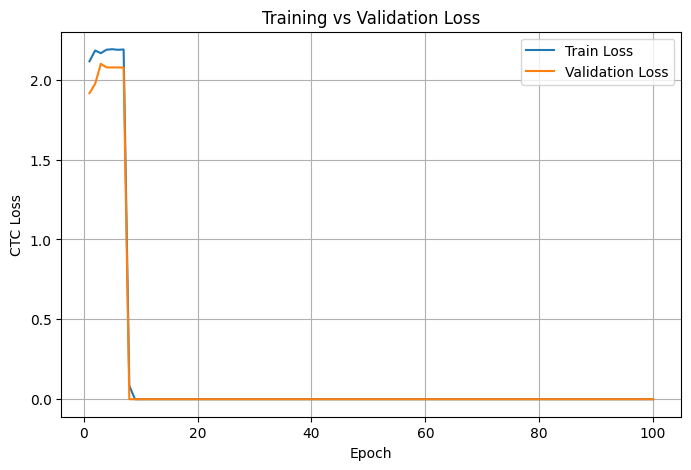

In [33]:
import os
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from tqdm import tqdm
import torchvision.models as models

# ===============================
# OCR Dataset
# ===============================
class OCRDataset(Dataset):
    def __init__(self, root, charset_path, img_h=32, img_w=512, debug=False):
        self.root = root
        self.img_h = img_h
        self.img_w = img_w
        self.debug = debug

        self.files = sorted([f for f in os.listdir(root) 
                             if f.endswith(".png") and os.path.getsize(os.path.join(root, f[:-4]+".txt")) > 0])

        with open(charset_path, "r", encoding="utf-8") as f:
            self.charset = ["blank"] + list(f.read().strip())
        self.char_to_idx = {c: i for i, c in enumerate(self.charset)}

    def encode(self, text):
        indices = [self.char_to_idx[c] for c in text if c in self.char_to_idx]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)
        txt_path = os.path.join(self.root, img_name[:-4] + ".txt")

        img = Image.open(img_path).convert("L")
        w, h = img.size
        new_h = self.img_h
        new_w = int(w * (new_h / h))
        img = img.resize((new_w, new_h), Image.LANCZOS)

        # pad width
        if new_w < self.img_w:
            padded = Image.new("L", (self.img_w, new_h), 255)
            padded.paste(img, (0, 0))
            img = padded
        else:
            img = img.crop((0, 0, self.img_w, new_h))

        img = np.array(img)
        img = torch.from_numpy(img).float().unsqueeze(0) / 255.0

        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        label = self.encode(text)

        return img, label

def ocr_collate(batch):
    imgs, labels, label_lens = [], [], []
    for img, label in batch:
        if len(label) == 0:
            continue
        imgs.append(img)
        labels.append(label)
        label_lens.append(len(label))

    if len(imgs) == 0:
        raise ValueError("All labels in this batch are empty.")

    imgs = torch.stack(imgs)
    labels = torch.cat(labels)
    label_lens = torch.tensor(label_lens, dtype=torch.long)
    return imgs, labels, label_lens

# ===============================
# CRNN Model with pretrained ResNet-18
# ===============================
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, img_channels=1):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        if img_channels != 3:
            self.conv1 = nn.Conv2d(img_channels, 64, 7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)  # [seq_len, batch, channels]
        return x

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return self.embedding(recurrent)

class OCRModelResNet18(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256, pretrained=True):
        super().__init__()
        self.cnn = ResNet18Backbone(pretrained=pretrained, img_channels=img_channels)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        features = self.cnn(x)
        return self.rnn(features)

    def compute_ctc_loss(self, preds, targets, pred_lengths, target_lengths):
        preds_log = preds.log_softmax(2)
        return self.ctc_loss(preds_log, targets, pred_lengths, target_lengths)

# ===============================
# Greedy CTC decoder
# ===============================
def greedy_ctc_decode(preds, charset):
    argmax = preds.argmax(2).cpu().numpy()
    decoded = []
    for b in range(argmax.shape[1]):
        last_idx = 0
        chars = []
        for t in range(argmax.shape[0]):
            idx = argmax[t, b]
            if idx != 0 and idx != last_idx:
                chars.append(charset[idx])
            last_idx = idx
        decoded.append("".join(chars))
    return decoded

# ===============================
# Load Config
# ===============================
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

learning_rate = float(cfg["learning_rate"])
weight_decay = float(cfg["weight_decay"])

# Use GPU 2
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# Prepare DataLoaders
# ===============================
train_dataset = OCRDataset("data/ocr_dataset/train", cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])
val_dataset   = OCRDataset("data/ocr_dataset/val", cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)

# ===============================
# Initialize model, optimizer, scheduler
# ===============================
model = OCRModelResNet18(num_classes=cfg["num_classes"], img_channels=cfg["num_channels"],
                         hidden_size=cfg["hidden_size"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg["scheduler_step"], gamma=cfg["scheduler_gamma"])

scaler = torch.cuda.amp.GradScaler()  # AMP scaler

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ===============================
# Training loop
# ===============================
train_losses = []
val_losses = []

for epoch in range(1, cfg["epochs"] + 1):
    # -------------------
    # Training
    # -------------------
    model.train()
    running_loss = 0.0

    for imgs, labels, label_lens in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg['epochs']} (Train)"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            preds = model(imgs)
            batch_size = imgs.size(0)
            pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long).to(device)

            max_label_len = label_lens.max().item()
            if preds.size(0) < max_label_len:
                pad = torch.zeros(max_label_len - preds.size(0), preds.size(1), preds.size(2), device=device)
                preds = torch.cat([preds, pad], dim=0)

            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)

        if torch.isnan(loss) or torch.isinf(loss):
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # -------------------
    # Validation
    # -------------------
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for imgs, labels, label_lens in tqdm(val_loader, desc=f"Epoch {epoch}/{cfg['epochs']} (Val)"):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            batch_size = imgs.size(0)
            pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long).to(device)

            max_label_len = label_lens.max().item()
            if preds.size(0) < max_label_len:
                pad = torch.zeros(max_label_len - preds.size(0), preds.size(1), preds.size(2), device=device)
                preds = torch.cat([preds, pad], dim=0)

            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)
            if torch.isnan(loss) or torch.isinf(loss):
                continue
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch}/{cfg['epochs']}] → Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save sample prediction (optional)
    sample_img, _, _ = next(iter(val_loader))
    sample_img = sample_img.to(device)
    preds = model(sample_img)
    decoded_texts = greedy_ctc_decode(preds, train_dataset.charset)
    save_path = os.path.join(checkpoint_dir, f"epoch_{epoch}_sample.png")
    save_image(sample_img[0], save_path)
    print(f"Sample prediction saved: {save_path} → Predicted text: {decoded_texts[0]}")

    # Save checkpoint
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"crnn_epoch_{epoch}.pth"))
    scheduler.step()

# -------------------
# Plot loss curves
# -------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
import os
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from torchvision import transforms
from tqdm import tqdm
import yaml

# ====== IMPORT YOUR MODEL & DATASTRUCTURES ======
from model_code import OCRModelResNet18     # <-- your model file
                                              # If model class is inside the same file, remove this line and paste the class definition here.


# ====== Load Charset ======
def load_charset(path):
    with open(path, "r", encoding="utf-8") as f:
        charset = ["blank"] + list(f.read().strip())
    return charset


# ====== Image Preprocessing (same as training) ======
def preprocess_image(img_path, img_h, img_w):
    img = Image.open(img_path).convert("L")
    w, h = img.size

    new_h = img_h
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.LANCZOS)

    if new_w < img_w:
        padded = Image.new("L", (img_w, new_h), 255)
        padded.paste(img, (0, 0))
        img = padded
    else:
        img = img.crop((0, 0, img_w, new_h))

    img = np.array(img)
    img = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0) / 255.0
    return img


# ====== Greedy CTC Decode with Confidence ======
def greedy_decode_with_conf(preds, charset):
    """
    preds: [T, B, C]
    returns: text, confidence
    """
    preds_softmax = preds.softmax(2)              # [T,B,C]
    pred_idx = preds_softmax.argmax(2).cpu()      # [T,B]

    batch_texts = []
    batch_confs = []

    for b in range(pred_idx.shape[1]):
        last = 0
        chars, probs = [], []

        for t in range(pred_idx.shape[0]):
            idx = pred_idx[t, b].item()
            prob = preds_softmax[t, b, idx].item()

            if idx != 0 and idx != last:   # skip blank + repeats
                chars.append(charset[idx])
                probs.append(prob)
            last = idx

        text = "".join(chars)
        conf = float(np.mean(probs)) if len(probs) > 0 else 0.0

        batch_texts.append(text)
        batch_confs.append(conf)

    return batch_texts, batch_confs


# =======================================================
#                   INFERENCE MAIN
# =======================================================
if __name__ == "__main__":

    # Load config
    with open("config.yaml", "r") as f:
        cfg = yaml.safe_load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load charset
    charset = load_charset(cfg["charset_path"])

    # Build model
    model = OCRModelResNet18(
        num_classes=cfg["num_classes"],
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"],
        pretrained=False
    ).to(device)

    # Load checkpoint
    checkpoint_path = "checkpoints/crnn_epoch_XX.pth"   # <-- REPLACE with last epoch file
    print(f"Loading checkpoint: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    test_dir = "data/ocr_dataset/test"
    test_images = sorted([f for f in os.listdir(test_dir) if f.endswith(".png")])

    print(f"Found {len(test_images)} test images.")

    for img_name in tqdm(test_images):
        img_path = os.path.join(test_dir, img_name)

        img_tensor = preprocess_image(img_path, cfg["img_height"], cfg["img_width"]).to(device)

        with torch.no_grad():
            preds = model(img_tensor)   # [T, B=1, C]

        # Decode
        decoded, conf = greedy_decode_with_conf(preds, charset)

        print(f"\nImage: {img_name}")
        print(f"Prediction: {decoded[0]}")
        print(f"Confidence: {conf[0]:.4f}")


ModuleNotFoundError: No module named 'model_code'

In [38]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import yaml
from tqdm import tqdm
import torchvision.models as models

# ============================================================
#      MODEL DEFINITIONS (copy from your training file)
# ============================================================

class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, img_channels=1):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)

        if img_channels != 3:
            self.conv1 = nn.Conv2d(img_channels, 64, 7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = resnet.conv1

        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)
        return x


class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return self.embedding(recurrent)


class OCRModelResNet18(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256, pretrained=True):
        super().__init__()
        self.cnn = ResNet18Backbone(pretrained=pretrained, img_channels=img_channels)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )

    def forward(self, x):
        features = self.cnn(x)
        return self.rnn(features)


# ============================================================
#                PREPROCESSING
# ============================================================

def preprocess_image(img_path, img_h, img_w):
    img = Image.open(img_path).convert("L")
    w, h = img.size

    new_h = img_h
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.LANCZOS)

    if new_w < img_w:
        padded = Image.new("L", (img_w, new_h), 255)
        padded.paste(img, (0, 0))
        img = padded
    else:
        img = img.crop((0, 0, img_w, new_h))

    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)
    return img


def load_charset(path):
    with open(path, "r", encoding="utf-8") as f:
        charset = ["blank"] + list(f.read().strip())
    return charset


# ============================================================
#          GREEDY DECODER WITH CONFIDENCE SCORE
# ============================================================

def greedy_decode_with_conf(preds, charset):
    """
    preds: [T, B, C]
    Returns: text, confidence
    """
    sm = preds.softmax(2)
    idxs = sm.argmax(2).cpu().numpy()

    batch_texts = []
    batch_confs = []

    for b in range(idxs.shape[1]):
        last = 0
        chars = []
        probs = []

        for t in range(idxs.shape[0]):
            idx = idxs[t, b]
            prob = sm[t, b, idx].item()

            if idx != 0 and idx != last:  # skip blank + repeat
                chars.append(charset[idx])
                probs.append(prob)

            last = idx

        text = "".join(chars)
        conf = float(np.mean(probs)) if probs else 0.0

        batch_texts.append(text)
        batch_confs.append(conf)

    return batch_texts, batch_confs


# ============================================================
#                        MAIN
# ============================================================

if __name__ == "__main__":
    # Load config
    with open("config.yaml", "r") as f:
        cfg = yaml.safe_load(f)

    charset = load_charset(cfg["charset_path"])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = OCRModelResNet18(
        num_classes=cfg["num_classes"],
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"],
        pretrained=False
    ).to(device)

    ckpt = "checkpoints/crnn_epoch_66.pth"   # <<< change this
    print("Loading:", ckpt)
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()

    test_dir = "data/ocr_dataset/test"
    test_files = sorted([f for f in os.listdir(test_dir) if f.endswith(".png")])

    for name in tqdm(test_files):
        img_path = os.path.join(test_dir, name)
        img = preprocess_image(img_path, cfg["img_height"], cfg["img_width"]).to(device)

        with torch.no_grad():
            preds = model(img)

        text, conf = greedy_decode_with_conf(preds, charset)

        print(f"\nImage: {name}")
        print("Prediction:", text[0])
        print("Confidence:", round(conf[0], 4))


Loading checkpoint: checkpoints/nepali_crnn_ctc.pth


RuntimeError: Error(s) in loading state_dict for OCRModelResNet18:
	Missing key(s) in state_dict: "cnn.conv1.weight", "cnn.bn1.weight", "cnn.bn1.bias", "cnn.bn1.running_mean", "cnn.bn1.running_var", "cnn.layer1.0.conv1.weight", "cnn.layer1.0.bn1.weight", "cnn.layer1.0.bn1.bias", "cnn.layer1.0.bn1.running_mean", "cnn.layer1.0.bn1.running_var", "cnn.layer1.0.conv2.weight", "cnn.layer1.0.bn2.weight", "cnn.layer1.0.bn2.bias", "cnn.layer1.0.bn2.running_mean", "cnn.layer1.0.bn2.running_var", "cnn.layer1.1.conv1.weight", "cnn.layer1.1.bn1.weight", "cnn.layer1.1.bn1.bias", "cnn.layer1.1.bn1.running_mean", "cnn.layer1.1.bn1.running_var", "cnn.layer1.1.conv2.weight", "cnn.layer1.1.bn2.weight", "cnn.layer1.1.bn2.bias", "cnn.layer1.1.bn2.running_mean", "cnn.layer1.1.bn2.running_var", "cnn.layer2.0.conv1.weight", "cnn.layer2.0.bn1.weight", "cnn.layer2.0.bn1.bias", "cnn.layer2.0.bn1.running_mean", "cnn.layer2.0.bn1.running_var", "cnn.layer2.0.conv2.weight", "cnn.layer2.0.bn2.weight", "cnn.layer2.0.bn2.bias", "cnn.layer2.0.bn2.running_mean", "cnn.layer2.0.bn2.running_var", "cnn.layer2.0.downsample.0.weight", "cnn.layer2.0.downsample.1.weight", "cnn.layer2.0.downsample.1.bias", "cnn.layer2.0.downsample.1.running_mean", "cnn.layer2.0.downsample.1.running_var", "cnn.layer2.1.conv1.weight", "cnn.layer2.1.bn1.weight", "cnn.layer2.1.bn1.bias", "cnn.layer2.1.bn1.running_mean", "cnn.layer2.1.bn1.running_var", "cnn.layer2.1.conv2.weight", "cnn.layer2.1.bn2.weight", "cnn.layer2.1.bn2.bias", "cnn.layer2.1.bn2.running_mean", "cnn.layer2.1.bn2.running_var", "cnn.layer3.0.conv1.weight", "cnn.layer3.0.bn1.weight", "cnn.layer3.0.bn1.bias", "cnn.layer3.0.bn1.running_mean", "cnn.layer3.0.bn1.running_var", "cnn.layer3.0.conv2.weight", "cnn.layer3.0.bn2.weight", "cnn.layer3.0.bn2.bias", "cnn.layer3.0.bn2.running_mean", "cnn.layer3.0.bn2.running_var", "cnn.layer3.0.downsample.0.weight", "cnn.layer3.0.downsample.1.weight", "cnn.layer3.0.downsample.1.bias", "cnn.layer3.0.downsample.1.running_mean", "cnn.layer3.0.downsample.1.running_var", "cnn.layer3.1.conv1.weight", "cnn.layer3.1.bn1.weight", "cnn.layer3.1.bn1.bias", "cnn.layer3.1.bn1.running_mean", "cnn.layer3.1.bn1.running_var", "cnn.layer3.1.conv2.weight", "cnn.layer3.1.bn2.weight", "cnn.layer3.1.bn2.bias", "cnn.layer3.1.bn2.running_mean", "cnn.layer3.1.bn2.running_var", "cnn.layer4.0.conv1.weight", "cnn.layer4.0.bn1.weight", "cnn.layer4.0.bn1.bias", "cnn.layer4.0.bn1.running_mean", "cnn.layer4.0.bn1.running_var", "cnn.layer4.0.conv2.weight", "cnn.layer4.0.bn2.weight", "cnn.layer4.0.bn2.bias", "cnn.layer4.0.bn2.running_mean", "cnn.layer4.0.bn2.running_var", "cnn.layer4.0.downsample.0.weight", "cnn.layer4.0.downsample.1.weight", "cnn.layer4.0.downsample.1.bias", "cnn.layer4.0.downsample.1.running_mean", "cnn.layer4.0.downsample.1.running_var", "cnn.layer4.1.conv1.weight", "cnn.layer4.1.bn1.weight", "cnn.layer4.1.bn1.bias", "cnn.layer4.1.bn1.running_mean", "cnn.layer4.1.bn1.running_var", "cnn.layer4.1.conv2.weight", "cnn.layer4.1.bn2.weight", "cnn.layer4.1.bn2.bias", "cnn.layer4.1.bn2.running_mean", "cnn.layer4.1.bn2.running_var". 
	Unexpected key(s) in state_dict: "cnn.cnn.0.weight", "cnn.cnn.0.bias", "cnn.cnn.3.weight", "cnn.cnn.3.bias", "cnn.cnn.6.weight", "cnn.cnn.6.bias", "cnn.cnn.8.weight", "cnn.cnn.8.bias", "cnn.cnn.8.running_mean", "cnn.cnn.8.running_var", "cnn.cnn.8.num_batches_tracked", "cnn.cnn.9.weight", "cnn.cnn.9.bias", "cnn.cnn.12.weight", "cnn.cnn.12.bias", "cnn.cnn.14.weight", "cnn.cnn.14.bias", "cnn.cnn.14.running_mean", "cnn.cnn.14.running_var", "cnn.cnn.14.num_batches_tracked", "cnn.cnn.15.weight", "cnn.cnn.15.bias", "cnn.cnn.18.weight", "cnn.cnn.18.bias". 

In [39]:
import os

print(os.listdir("data/ocr_dataset/test"))


['00312.png', '00390.txt', '00228.txt', '00104.txt', '00209.txt', '00455.png', '00471.png', '00102.png', '00022.png', '00024.png', '00096.txt', '00403.txt', '00441.txt', '00288.png', '00399.png', '00309.txt', '00424.png', '00094.txt', '00431.txt', '00138.txt', '00373.txt', '00456.png', '00267.png', '00109.txt', '00133.txt', '00309.png', '00448.png', '00063.txt', '00213.txt', '00397.png', '00315.txt', '00442.png', '00197.png', '00438.txt', '00366.png', '00233.txt', '00043.png', '00263.png', '00205.txt', '00402.png', '00299.png', '00113.png', '00093.png', '00235.txt', '00272.txt', '00179.txt', '00095.txt', '00262.png', '00306.txt', '00433.png', '00059.png', '00352.txt', '00379.png', '00081.png', '00087.txt', '00165.png', '00297.txt', '00290.txt', '00258.txt', '00219.txt', '00303.txt', '00499.png', '00012.png', '00430.png', '00447.png', '00239.txt', '00370.txt', '00394.txt', '00098.png', '00242.png', '00199.png', '00344.png', '00140.txt', '00044.png', '00027.png', '00361.png', '00069.txt'

In [45]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import yaml
import random
from tqdm import tqdm
import torchvision.models as models

# ============================================================
# MODEL DEFINITIONS (must match training exactly)
# ============================================================

class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, img_channels=1):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)

        if img_channels != 3:
            self.conv1 = nn.Conv2d(img_channels, 64, 7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = resnet.conv1

        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)  # [seq_len, batch, channels]
        return x

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return self.embedding(recurrent)

class OCRModelResNet18(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256, pretrained=True):
        super().__init__()
        self.cnn = ResNet18Backbone(pretrained=pretrained, img_channels=img_channels)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        features = self.cnn(x)
        return self.rnn(features)

# ============================================================
# PREPROCESSING
# ============================================================

def preprocess_image(img_path, img_h, img_w):
    img = Image.open(img_path).convert("L")
    w, h = img.size
    new_h = img_h
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.LANCZOS)

    if new_w < img_w:
        padded = Image.new("L", (img_w, new_h), 255)
        padded.paste(img, (0, 0))
        img = padded
    else:
        img = img.crop((0, 0, img_w, new_h))

    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return img

def load_charset(path):
    with open(path, "r", encoding="utf-8") as f:
        return ["blank"] + list(f.read().strip())

# ============================================================
# GREEDY DECODER WITH CONFIDENCE
# ============================================================

def decode_with_conf(preds, charset):
    sm = preds.softmax(2)
    idxs = sm.argmax(2).cpu().numpy()
    all_texts, all_confs = [], []

    for b in range(idxs.shape[1]):
        last = 0
        chars, probs = [], []
        for t in range(idxs.shape[0]):
            i = idxs[t, b]
            p = sm[t, b, i].item()
            if i != 0 and i != last:  # skip blank + repeat
                chars.append(charset[i])
                probs.append(p)
            last = i
        all_texts.append("".join(chars))
        all_confs.append(float(np.mean(probs)) if probs else 0.0)
    return all_texts, all_confs

# ============================================================
# MAIN INFERENCE
# ============================================================

if __name__ == "__main__":
    # Load config
    with open("config.yaml", "r") as f:
        cfg = yaml.safe_load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    charset = load_charset(cfg["charset_path"])

    # Initialize model
    model = OCRModelResNet18(
        num_classes=cfg["num_classes"],
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"],
        pretrained=True
    ).to(device)

    # Load checkpoint (state_dict directly)
    ckpt_path = "checkpoints/crnn_epoch_66.pth"
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state, strict=True)
    model.eval()
    print(f"Loaded checkpoint: {ckpt_path}")

    # Get 15 random test images
    test_dir = "data/ocr_dataset/test"
    png_files = sorted([f for f in os.listdir(test_dir) if f.endswith(".png")])
    sample_files = random.sample(png_files, 15)

    print("\n========== 15 RANDOM TEST IMAGES ==========\n")
    for img_name in sample_files:
        img_path = os.path.join(test_dir, img_name)
        txt_path = img_path.replace(".png", ".txt")

        with open(txt_path, "r", encoding="utf-8") as f:
            gt = f.read().strip()

        img = preprocess_image(img_path, cfg["img_height"], cfg["img_width"]).to(device)

        with torch.no_grad():
            preds = model(img)

        text, conf = decode_with_conf(preds, charset)

        print(f"Image: {img_name}")
        print("Ground Truth :", gt)
        print("Prediction   :", text[0])
        print("Confidence   :", round(conf[0], 4))
        print("--------------------------------------")


Loaded checkpoint: checkpoints/crnn_epoch_66.pth

========== 15 RANDOM TEST IMAGES ==========

Image: 00215.png
Ground Truth : कमनवेल्थका
Prediction   : 
Confidence   : 0.0
--------------------------------------
Image: 00087.png
Ground Truth : विद्युतीयउर्जाको
Prediction   : 
Confidence   : 0.0
--------------------------------------
Image: 00311.png
Ground Truth : युनाइटेडबाटनै
Prediction   : 
Confidence   : 0.0
--------------------------------------
Image: 00388.png
Ground Truth : ओलकमाया
Prediction   : 
Confidence   : 0.0
--------------------------------------
Image: 00156.png
Ground Truth : लापरवाह्रीले
Prediction   : 
Confidence   : 0.0
--------------------------------------
Image: 00155.png
Ground Truth : तारजालिसहितको
Prediction   : 
Confidence   : 0.0
--------------------------------------
Image: 00073.png
Ground Truth : अर्गनाईजेशनसँग
Prediction   : 
Confidence   : 0.0
--------------------------------------
Image: 00014.png
Ground Truth : हमालद्धारा
Prediction   : 
Confidence  

In [41]:
import torch
ckpt = torch.load("checkpoints/crnn_epoch_66.pth", map_location="cpu")
print(len(ckpt))


140


Using device: cuda:2
Number of classes (including blank): 156


/tmp/ipykernel_3323772/1517452690.py:232: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_3323772/1517452690.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.51it/s]

Epoch [1/100] → Train Loss: 1.7868, Val Loss: 1.5989


Sample prediction saved: checkpoints/epoch_1_sample.png → Predicted text: साा


Epoch 2/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.77it/s]

Epoch [2/100] → Train Loss: 1.6572, Val Loss: 1.5619


Sample prediction saved: checkpoints/epoch_2_sample.png → Predicted text: सिसिका


Epoch 3/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.10it/s]

Epoch [3/100] → Train Loss: 1.6243, Val Loss: 1.5580


Sample prediction saved: checkpoints/epoch_3_sample.png → Predicted text: सरालाक


Epoch 4/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.46it/s]

Epoch [4/100] → Train Loss: 1.6140, Val Loss: 1.5323


Sample prediction saved: checkpoints/epoch_4_sample.png → Predicted text: सराल


Epoch 5/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]

Epoch [5/100] → Train Loss: 1.5804, Val Loss: 1.4757


Sample prediction saved: checkpoints/epoch_5_sample.png → Predicted text: बारा


Epoch 6/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]

Epoch [6/100] → Train Loss: 1.5455, Val Loss: 1.4855


Sample prediction saved: checkpoints/epoch_6_sample.png → Predicted text: सान


Epoch 7/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.93it/s]

Epoch [7/100] → Train Loss: 1.5237, Val Loss: 1.4440


Sample prediction saved: checkpoints/epoch_7_sample.png → Predicted text: साको


Epoch 8/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.65it/s]


Epoch [8/100] → Train Loss: 1.4942, Val Loss: 1.4219
Sample prediction saved: checkpoints/epoch_8_sample.png → Predicted text: अाको


Epoch 9/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.10it/s]

Epoch [9/100] → Train Loss: 1.4814, Val Loss: 1.4531


Sample prediction saved: checkpoints/epoch_9_sample.png → Predicted text: साको


Epoch 10/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]

Epoch [10/100] → Train Loss: 1.4610, Val Loss: 1.4207


Sample prediction saved: checkpoints/epoch_10_sample.png → Predicted text: आाि


Epoch 11/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.68it/s]

Epoch [11/100] → Train Loss: 1.4451, Val Loss: 1.3732


Sample prediction saved: checkpoints/epoch_11_sample.png → Predicted text: साको


Epoch 12/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]

Epoch [12/100] → Train Loss: 1.4224, Val Loss: 1.3654


Sample prediction saved: checkpoints/epoch_12_sample.png → Predicted text: साको


Epoch 13/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.01it/s]

Epoch [13/100] → Train Loss: 1.4061, Val Loss: 1.3495


Sample prediction saved: checkpoints/epoch_13_sample.png → Predicted text: सािको


Epoch 14/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.53it/s]

Epoch [14/100] → Train Loss: 1.3778, Val Loss: 1.4392


Sample prediction saved: checkpoints/epoch_14_sample.png → Predicted text: स्ि


Epoch 15/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.97it/s]

Epoch [15/100] → Train Loss: 1.3737, Val Loss: 1.3819


Sample prediction saved: checkpoints/epoch_15_sample.png → Predicted text: सालको


Epoch 16/100 (Val): 100%|██████████| 8/8 [00:01<00:00,  6.90it/s]

Epoch [16/100] → Train Loss: 1.3241, Val Loss: 1.4440


Sample prediction saved: checkpoints/epoch_16_sample.png → Predicted text: पा्ि


Epoch 17/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]

Epoch [17/100] → Train Loss: 1.3114, Val Loss: 1.2859


Sample prediction saved: checkpoints/epoch_17_sample.png → Predicted text: पासिन


Epoch 18/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]

Epoch [18/100] → Train Loss: 1.2929, Val Loss: 1.3752


Sample prediction saved: checkpoints/epoch_18_sample.png → Predicted text: सालिा


Epoch 19/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.05it/s]

Epoch [19/100] → Train Loss: 1.2783, Val Loss: 1.2827


Sample prediction saved: checkpoints/epoch_19_sample.png → Predicted text: पालिा


Epoch 20/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.71it/s]

Epoch [20/100] → Train Loss: 1.2680, Val Loss: 1.3073


Sample prediction saved: checkpoints/epoch_20_sample.png → Predicted text: सालि


Epoch 21/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.33it/s]

Epoch [21/100] → Train Loss: 1.2547, Val Loss: 1.2978


Sample prediction saved: checkpoints/epoch_21_sample.png → Predicted text: सासीित


Epoch 22/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.41it/s]

Epoch [22/100] → Train Loss: 1.2356, Val Loss: 1.2984


Sample prediction saved: checkpoints/epoch_22_sample.png → Predicted text: पासिा


Epoch 23/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.15it/s]

Epoch [23/100] → Train Loss: 1.2251, Val Loss: 1.3055


Sample prediction saved: checkpoints/epoch_23_sample.png → Predicted text: पासि


Epoch 24/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.69it/s]

Epoch [24/100] → Train Loss: 1.2146, Val Loss: 1.3293


Sample prediction saved: checkpoints/epoch_24_sample.png → Predicted text: सासिा


Epoch 25/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.83it/s]

Epoch [25/100] → Train Loss: 1.2008, Val Loss: 1.3160


Sample prediction saved: checkpoints/epoch_25_sample.png → Predicted text: पासिा


Epoch 26/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.93it/s]

Epoch [26/100] → Train Loss: 1.1777, Val Loss: 1.3074


Sample prediction saved: checkpoints/epoch_26_sample.png → Predicted text: पासित


Epoch 27/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.13it/s]

Epoch [27/100] → Train Loss: 1.1723, Val Loss: 1.3357


Sample prediction saved: checkpoints/epoch_27_sample.png → Predicted text: पारसिा


Epoch 28/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.77it/s]

Epoch [28/100] → Train Loss: 1.1448, Val Loss: 1.2878


Sample prediction saved: checkpoints/epoch_28_sample.png → Predicted text: पारसित


Epoch 29/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.14it/s]

Epoch [29/100] → Train Loss: 1.1449, Val Loss: 1.3316


Sample prediction saved: checkpoints/epoch_29_sample.png → Predicted text: पारलिया


Epoch 30/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.08it/s]

Epoch [30/100] → Train Loss: 1.1355, Val Loss: 1.2901


Sample prediction saved: checkpoints/epoch_30_sample.png → Predicted text: पारसित


Epoch 31/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.33it/s]

Epoch [31/100] → Train Loss: 1.0925, Val Loss: 1.2944


Sample prediction saved: checkpoints/epoch_31_sample.png → Predicted text: पासित


Epoch 32/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]

Epoch [32/100] → Train Loss: 1.0676, Val Loss: 1.3049


Sample prediction saved: checkpoints/epoch_32_sample.png → Predicted text: पारसि


Epoch 33/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.28it/s]

Epoch [33/100] → Train Loss: 1.0513, Val Loss: 1.3372


Sample prediction saved: checkpoints/epoch_33_sample.png → Predicted text: पासीि


Epoch 34/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.92it/s]

Epoch [34/100] → Train Loss: 1.0392, Val Loss: 1.3023


Sample prediction saved: checkpoints/epoch_34_sample.png → Predicted text: पारसित


Epoch 35/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.69it/s]

Epoch [35/100] → Train Loss: 1.0290, Val Loss: 1.3055


Sample prediction saved: checkpoints/epoch_35_sample.png → Predicted text: पारसिग


Epoch 36/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.92it/s]

Epoch [36/100] → Train Loss: 1.0160, Val Loss: 1.3258


Sample prediction saved: checkpoints/epoch_36_sample.png → Predicted text: पारसित


Epoch 37/100 (Val): 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]

Epoch [37/100] → Train Loss: 1.0059, Val Loss: 1.3411


Sample prediction saved: checkpoints/epoch_37_sample.png → Predicted text: पारसिए


Epoch 38/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]

Epoch [38/100] → Train Loss: 0.9980, Val Loss: 1.3336


Sample prediction saved: checkpoints/epoch_38_sample.png → Predicted text: पारसिन


Epoch 39/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]

Epoch [39/100] → Train Loss: 0.9916, Val Loss: 1.3262


Sample prediction saved: checkpoints/epoch_39_sample.png → Predicted text: पारसित


Epoch 40/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.84it/s]

Epoch [40/100] → Train Loss: 0.9731, Val Loss: 1.3326


Sample prediction saved: checkpoints/epoch_40_sample.png → Predicted text: पारसियर


Epoch 41/100 (Val): 100%|██████████| 8/8 [00:01<00:00,  6.38it/s]

Epoch [41/100] → Train Loss: 0.9617, Val Loss: 1.3335


Sample prediction saved: checkpoints/epoch_41_sample.png → Predicted text: पारसिग


Epoch 42/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.17it/s]

Epoch [42/100] → Train Loss: 0.9553, Val Loss: 1.3407


Sample prediction saved: checkpoints/epoch_42_sample.png → Predicted text: रारसित


Epoch 43/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

Epoch [43/100] → Train Loss: 0.9426, Val Loss: 1.3456


Sample prediction saved: checkpoints/epoch_43_sample.png → Predicted text: पारसित


Epoch 44/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.94it/s]

Epoch [44/100] → Train Loss: 0.9273, Val Loss: 1.3687


Sample prediction saved: checkpoints/epoch_44_sample.png → Predicted text: जारसीिर


Epoch 45/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.68it/s]

Epoch [45/100] → Train Loss: 0.9153, Val Loss: 1.3700


Sample prediction saved: checkpoints/epoch_45_sample.png → Predicted text: पारसिर


Epoch 46/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.75it/s]

Epoch [46/100] → Train Loss: 0.8861, Val Loss: 1.3507


Sample prediction saved: checkpoints/epoch_46_sample.png → Predicted text: पारलिएर


Epoch 47/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]

Epoch [47/100] → Train Loss: 0.8717, Val Loss: 1.3588


Sample prediction saved: checkpoints/epoch_47_sample.png → Predicted text: परारसिर


Epoch 48/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.51it/s]

Epoch [48/100] → Train Loss: 0.8652, Val Loss: 1.3655


Sample prediction saved: checkpoints/epoch_48_sample.png → Predicted text: पाउसिए


Epoch 49/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.38it/s]

Epoch [49/100] → Train Loss: 0.8523, Val Loss: 1.3625


Sample prediction saved: checkpoints/epoch_49_sample.png → Predicted text: पारसिर


Epoch 50/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]

Epoch [50/100] → Train Loss: 0.8483, Val Loss: 1.3762


Sample prediction saved: checkpoints/epoch_50_sample.png → Predicted text: पराउसिया


Epoch 51/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.89it/s]

Epoch [51/100] → Train Loss: 0.8445, Val Loss: 1.3805


Sample prediction saved: checkpoints/epoch_51_sample.png → Predicted text: पाउसिएर


Epoch 52/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.77it/s]

Epoch [52/100] → Train Loss: 0.8358, Val Loss: 1.3816


Sample prediction saved: checkpoints/epoch_52_sample.png → Predicted text: पराउसिएर


Epoch 53/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.79it/s]

Epoch [53/100] → Train Loss: 0.8272, Val Loss: 1.3764


Sample prediction saved: checkpoints/epoch_53_sample.png → Predicted text: पारसिग


Epoch 54/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]

Epoch [54/100] → Train Loss: 0.8253, Val Loss: 1.3815


Sample prediction saved: checkpoints/epoch_54_sample.png → Predicted text: पाउसिर


Epoch 55/100 (Val): 100%|██████████| 8/8 [00:01<00:00,  6.86it/s]

Epoch [55/100] → Train Loss: 0.8096, Val Loss: 1.3895


Sample prediction saved: checkpoints/epoch_55_sample.png → Predicted text: पाउसिर


Epoch 56/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.39it/s]

Epoch [56/100] → Train Loss: 0.8067, Val Loss: 1.4038


Sample prediction saved: checkpoints/epoch_56_sample.png → Predicted text: राउसिर


Epoch 57/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.92it/s]

Epoch [57/100] → Train Loss: 0.7968, Val Loss: 1.4038


Sample prediction saved: checkpoints/epoch_57_sample.png → Predicted text: परारसित


Epoch 58/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.15it/s]

Epoch [58/100] → Train Loss: 0.7817, Val Loss: 1.4065


Sample prediction saved: checkpoints/epoch_58_sample.png → Predicted text: परारसहित


Epoch 59/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.28it/s]

Epoch [59/100] → Train Loss: 0.7776, Val Loss: 1.4181


Sample prediction saved: checkpoints/epoch_59_sample.png → Predicted text: परारसिर


Epoch 60/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.98it/s]

Epoch [60/100] → Train Loss: 0.7725, Val Loss: 1.4236


Sample prediction saved: checkpoints/epoch_60_sample.png → Predicted text: पारसिया


Epoch 61/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.24it/s]

Epoch [61/100] → Train Loss: 0.7509, Val Loss: 1.4127


Sample prediction saved: checkpoints/epoch_61_sample.png → Predicted text: पराउसिर


Epoch 62/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.66it/s]

Epoch [62/100] → Train Loss: 0.7446, Val Loss: 1.4257


Sample prediction saved: checkpoints/epoch_62_sample.png → Predicted text: पारलियर


Epoch 63/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.07it/s]

Epoch [63/100] → Train Loss: 0.7429, Val Loss: 1.4293


Sample prediction saved: checkpoints/epoch_63_sample.png → Predicted text: पारसिएर


Epoch 64/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.28it/s]

Epoch [64/100] → Train Loss: 0.7410, Val Loss: 1.4339


Sample prediction saved: checkpoints/epoch_64_sample.png → Predicted text: पारलिया


Epoch 65/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]

Epoch [65/100] → Train Loss: 0.7275, Val Loss: 1.4318


Sample prediction saved: checkpoints/epoch_65_sample.png → Predicted text: उपारसिर


Epoch 66/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]

Epoch [66/100] → Train Loss: 0.7243, Val Loss: 1.4417


Sample prediction saved: checkpoints/epoch_66_sample.png → Predicted text: परारसिर


Epoch 67/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]

Epoch [67/100] → Train Loss: 0.7184, Val Loss: 1.4369


Sample prediction saved: checkpoints/epoch_67_sample.png → Predicted text: परारसिर


Epoch 68/100 (Val): 100%|██████████| 8/8 [00:01<00:00,  6.72it/s]

Epoch [68/100] → Train Loss: 0.7179, Val Loss: 1.4421


Sample prediction saved: checkpoints/epoch_68_sample.png → Predicted text: पारलिर


Epoch 69/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.09it/s]

Epoch [69/100] → Train Loss: 0.7176, Val Loss: 1.4466


Sample prediction saved: checkpoints/epoch_69_sample.png → Predicted text: पारलिया


Epoch 70/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.09it/s]

Epoch [70/100] → Train Loss: 0.7165, Val Loss: 1.4435


Sample prediction saved: checkpoints/epoch_70_sample.png → Predicted text: पारसिर


Epoch 71/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]

Epoch [71/100] → Train Loss: 0.7096, Val Loss: 1.4408


Sample prediction saved: checkpoints/epoch_71_sample.png → Predicted text: परारसिर


Epoch 72/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.90it/s]

Epoch [72/100] → Train Loss: 0.7065, Val Loss: 1.4486


Sample prediction saved: checkpoints/epoch_72_sample.png → Predicted text: उरारसित


Epoch 73/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.06it/s]

Epoch [73/100] → Train Loss: 0.6942, Val Loss: 1.4509


Sample prediction saved: checkpoints/epoch_73_sample.png → Predicted text: परारसिएर


Epoch 74/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]

Epoch [74/100] → Train Loss: 0.6959, Val Loss: 1.4511


Sample prediction saved: checkpoints/epoch_74_sample.png → Predicted text: परारसिर


Epoch 75/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.10it/s]

Epoch [75/100] → Train Loss: 0.6903, Val Loss: 1.4612


Sample prediction saved: checkpoints/epoch_75_sample.png → Predicted text: पारसिर


Epoch 76/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.35it/s]

Epoch [76/100] → Train Loss: 0.6804, Val Loss: 1.4560


Sample prediction saved: checkpoints/epoch_76_sample.png → Predicted text: परारलिर


Epoch 77/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.08it/s]

Epoch [77/100] → Train Loss: 0.6802, Val Loss: 1.4630


Sample prediction saved: checkpoints/epoch_77_sample.png → Predicted text: पारलिर


Epoch 78/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.54it/s]

Epoch [78/100] → Train Loss: 0.6756, Val Loss: 1.4578


Sample prediction saved: checkpoints/epoch_78_sample.png → Predicted text: परारसिर


Epoch 79/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]

Epoch [79/100] → Train Loss: 0.6735, Val Loss: 1.4600


Sample prediction saved: checkpoints/epoch_79_sample.png → Predicted text: पारलिएर


Epoch 80/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]

Epoch [80/100] → Train Loss: 0.6694, Val Loss: 1.4611


Sample prediction saved: checkpoints/epoch_80_sample.png → Predicted text: परारसिर


Epoch 81/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.95it/s]

Epoch [81/100] → Train Loss: 0.6644, Val Loss: 1.4631


Sample prediction saved: checkpoints/epoch_81_sample.png → Predicted text: परारलिर


Epoch 82/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.56it/s]

Epoch [82/100] → Train Loss: 0.6650, Val Loss: 1.4630


Sample prediction saved: checkpoints/epoch_82_sample.png → Predicted text: परारलिर


Epoch 83/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.24it/s]

Epoch [83/100] → Train Loss: 0.6620, Val Loss: 1.4622


Sample prediction saved: checkpoints/epoch_83_sample.png → Predicted text: परारलिर


Epoch 84/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.47it/s]

Epoch [84/100] → Train Loss: 0.6637, Val Loss: 1.4613


Sample prediction saved: checkpoints/epoch_84_sample.png → Predicted text: परारलिएर


Epoch 85/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.30it/s]

Epoch [85/100] → Train Loss: 0.6517, Val Loss: 1.4736


Sample prediction saved: checkpoints/epoch_85_sample.png → Predicted text: परारलिर


Epoch 86/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.13it/s]

Epoch [86/100] → Train Loss: 0.6553, Val Loss: 1.4730


Sample prediction saved: checkpoints/epoch_86_sample.png → Predicted text: परारलिर


Epoch 87/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.39it/s]

Epoch [87/100] → Train Loss: 0.6518, Val Loss: 1.4738


Sample prediction saved: checkpoints/epoch_87_sample.png → Predicted text: परारलिर


Epoch 88/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.98it/s]

Epoch [88/100] → Train Loss: 0.6517, Val Loss: 1.4790


Sample prediction saved: checkpoints/epoch_88_sample.png → Predicted text: परारलिर


Epoch 89/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.91it/s]

Epoch [89/100] → Train Loss: 0.6484, Val Loss: 1.4832


Sample prediction saved: checkpoints/epoch_89_sample.png → Predicted text: पारलिया


Epoch 90/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.87it/s]

Epoch [90/100] → Train Loss: 0.6470, Val Loss: 1.4855


Sample prediction saved: checkpoints/epoch_90_sample.png → Predicted text: पारलिएर


Epoch 91/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.45it/s]

Epoch [91/100] → Train Loss: 0.6400, Val Loss: 1.4807


Sample prediction saved: checkpoints/epoch_91_sample.png → Predicted text: परारलिर


Epoch 92/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.91it/s]

Epoch [92/100] → Train Loss: 0.6405, Val Loss: 1.4823


Sample prediction saved: checkpoints/epoch_92_sample.png → Predicted text: परारलिर


Epoch 93/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.53it/s]

Epoch [93/100] → Train Loss: 0.6404, Val Loss: 1.4793


Sample prediction saved: checkpoints/epoch_93_sample.png → Predicted text: परारलिएर


Epoch 94/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.48it/s]

Epoch [94/100] → Train Loss: 0.6365, Val Loss: 1.4819


Sample prediction saved: checkpoints/epoch_94_sample.png → Predicted text: परारलिर


Epoch 95/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.04it/s]

Epoch [95/100] → Train Loss: 0.6349, Val Loss: 1.4836


Sample prediction saved: checkpoints/epoch_95_sample.png → Predicted text: परारलिर


Epoch 96/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]

Epoch [96/100] → Train Loss: 0.6363, Val Loss: 1.4870


Sample prediction saved: checkpoints/epoch_96_sample.png → Predicted text: परारलिएर


Epoch 97/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.53it/s]

Epoch [97/100] → Train Loss: 0.6363, Val Loss: 1.4848


Sample prediction saved: checkpoints/epoch_97_sample.png → Predicted text: परारलिर


Epoch 98/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.85it/s]

Epoch [98/100] → Train Loss: 0.6331, Val Loss: 1.4877


Sample prediction saved: checkpoints/epoch_98_sample.png → Predicted text: परारलिएर


Epoch 99/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.54it/s]


Epoch [99/100] → Train Loss: 0.6299, Val Loss: 1.4846
Sample prediction saved: checkpoints/epoch_99_sample.png → Predicted text: परारलिर


Epoch 100/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.97it/s]

Epoch [100/100] → Train Loss: 0.6278, Val Loss: 1.4876


Sample prediction saved: checkpoints/epoch_100_sample.png → Predicted text: परारलिर


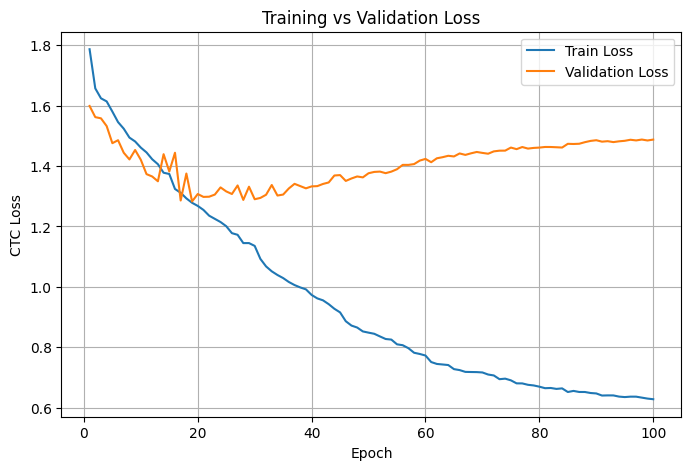

In [48]:
# train_crnn_resnet18.py
import os
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from tqdm import tqdm
import torchvision.models as models

# -----------------------
# OCR Dataset
# -----------------------
class OCRDataset(Dataset):
    def __init__(self, root, charset_path, img_h=32, img_w=512, debug=False):
        self.root = root
        self.img_h = img_h
        self.img_w = img_w
        self.debug = debug

        # select PNG files that have a non-empty .txt label
        files = []
        for f in sorted(os.listdir(root)):
            if f.endswith(".png"):
                tpath = os.path.join(root, f[:-4] + ".txt")
                if os.path.exists(tpath) and os.path.getsize(tpath) > 0:
                    files.append(f)
        self.files = files

        with open(charset_path, "r", encoding="utf-8") as f:
            charset_txt = f.read().strip()
        # keep blank at index 0 for CTC blank
        self.charset = ["<blank>"] + list(charset_txt)
        self.char_to_idx = {c: i for i, c in enumerate(self.charset)}

    def encode(self, text):
        indices = [self.char_to_idx[c] for c in text if c in self.char_to_idx]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)
        txt_path = os.path.join(self.root, img_name[:-4] + ".txt")

        img = Image.open(img_path).convert("L")
        w, h = img.size
        new_h = self.img_h
        new_w = int(w * (new_h / h))
        img = img.resize((new_w, new_h), Image.LANCZOS)

        # pad or crop width to fixed img_w
        if new_w < self.img_w:
            padded = Image.new("L", (self.img_w, new_h), 255)
            padded.paste(img, (0, 0))
            img = padded
        else:
            img = img.crop((0, 0, self.img_w, new_h))

        img = np.array(img).astype(np.float32) / 255.0  # [H, W]
        # normalize to mean=0.5, std=0.5 (common)
        img = (img - 0.5) / 0.5
        img = torch.from_numpy(img).unsqueeze(0)  # [1, H, W]

        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        label = self.encode(text)

        return img, label

def ocr_collate(batch):
    imgs = []
    labels = []
    label_lens = []
    for img, label in batch:
        if label.numel() == 0:
            continue
        imgs.append(img)
        labels.append(label)
        label_lens.append(label.size(0))

    if len(imgs) == 0:
        raise ValueError("All labels in this batch are empty.")

    imgs = torch.stack(imgs, dim=0)                 # [B, 1, H, W]
    labels_cat = torch.cat(labels, dim=0)           # concatenated targets as 1D
    label_lens = torch.tensor(label_lens, dtype=torch.long)
    return imgs, labels_cat, label_lens

# -----------------------
# Model: ResNet18 backbone + BiLSTMs
# -----------------------
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, img_channels=1):
        super().__init__()
        # use new-style weights enum in recent torchvision
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        if img_channels != 3:
            # replace conv1 to accept single channel
            self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        # keep adaptive pooling so height -> 1 (sequence over width)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        # x: [B, C, H, W]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # [B, 512, H', W']
        x = self.adaptive_pool(x)     # [B, 512, 1, W_seq]
        x = x.squeeze(2)             # [B, 512, W_seq]
        x = x.permute(2, 0, 1)       # [T=W_seq, B, C=512]
        return x

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)    # recurrent: [T, B, 2*hidden]
        output = self.embedding(recurrent)  # [T, B, output_size]
        return output

class OCRModelResNet18(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256, pretrained=True):
        super().__init__()
        self.cnn = ResNet18Backbone(pretrained=pretrained, img_channels=img_channels)
        # channel from ResNet18 is 512
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        features = self.cnn(x)   # [T, B, C]
        out = self.rnn(features) # [T, B, num_classes]
        return out

    def compute_ctc_loss(self, preds, targets, pred_lengths, target_lengths):
        # preds: [T, B, C] (logits)
        preds_log = preds.log_softmax(2)  # log-probs over classes
        # CTC in PyTorch expects (T, N, C)
        return self.ctc_loss(preds_log, targets, pred_lengths, target_lengths)

# -----------------------
# Greedy decode
# -----------------------
def greedy_ctc_decode(preds, charset):
    # preds: [T, B, C] logits or probs
    argmax = preds.argmax(2).cpu().numpy()  # [T, B]
    decoded = []
    for b in range(argmax.shape[1]):
        last_idx = 0
        chars = []
        for t in range(argmax.shape[0]):
            idx = argmax[t, b]
            if idx != 0 and idx != last_idx:  # skip blanks and repeats
                chars.append(charset[idx])
            last_idx = idx
        decoded.append("".join(chars))
    return decoded

# -----------------------
# Load config
# -----------------------
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

learning_rate = float(cfg.get("learning_rate", 1e-4))
weight_decay = float(cfg.get("weight_decay", 1e-5))

# Use GPU device specified by environment variable if available
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------
# Prepare datasets & loaders
# -----------------------
train_dataset = OCRDataset("data/ocr_dataset/train", cfg["charset_path"],
                           img_h=cfg.get("img_height", 32), img_w=cfg.get("img_width", 512))
val_dataset = OCRDataset("data/ocr_dataset/val", cfg["charset_path"],
                         img_h=cfg.get("img_height", 32), img_w=cfg.get("img_width", 512))

# compute num_classes from charset (ensure cfg num_classes not stale)
num_classes = len(train_dataset.charset)
print(f"Number of classes (including blank): {num_classes}")

# DataLoader note: on Windows, set num_workers=0 to avoid issues
train_loader = DataLoader(train_dataset, batch_size=cfg.get("batch_size", 8), shuffle=True,
                          collate_fn=ocr_collate, num_workers=cfg.get("num_workers", 4), pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.get("batch_size", 8), shuffle=False,
                        collate_fn=ocr_collate, num_workers=cfg.get("num_workers", 4), pin_memory=True)

# -----------------------
# Init model, optimizer, scheduler, AMP scaler
# -----------------------
model = OCRModelResNet18(num_classes=num_classes, img_channels=cfg.get("num_channels", 1),
                         hidden_size=cfg.get("hidden_size", 256), pretrained=cfg.get("pretrained", True)).to(device)

# Optional: freeze CNN backbone initially (recommended for small datasets)
if cfg.get("freeze_backbone_epochs", 0) > 0:
    for p in model.cnn.parameters():
        p.requires_grad = False
    print(f"Backbone frozen for first {cfg.get('freeze_backbone_epochs')} epochs.")

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg.get("scheduler_step", 15), gamma=cfg.get("scheduler_gamma", 0.5))

scaler = torch.cuda.amp.GradScaler()

checkpoint_dir = cfg.get("checkpoint_dir", "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# -----------------------
# Training loop
# -----------------------
epochs = cfg.get("epochs", 30)
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    train_steps = 0

    # If we freeze backbone for some epochs, unfreeze at the right epoch
    if cfg.get("freeze_backbone_epochs", 0) > 0 and epoch == cfg.get("freeze_backbone_epochs") + 1:
        for p in model.cnn.parameters():
            p.requires_grad = True
        # re-create optimizer so it includes backbone params
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.get("scheduler_step", 15), gamma=cfg.get("scheduler_gamma", 0.5))
        print("Unfroze backbone and reinitialized optimizer.")

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} (Train)")
    for imgs, labels, label_lens in pbar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device)
        label_lens = label_lens.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            preds = model(imgs)  # [T, B, C]
            batch_size = imgs.size(0)
            T = preds.size(0)
            # pred_lengths: actual valid timesteps for each sample
            pred_lengths = torch.full((batch_size,), T, dtype=torch.long, device=device)

            # targets = concatenated labels (already in labels)
            target_lengths = label_lens  # lengths per sample

            loss = model.compute_ctc_loss(preds, labels, pred_lengths, target_lengths)

        if torch.isnan(loss) or torch.isinf(loss):
            print("Skipping batch due to NaN/inf loss.")
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        train_steps += 1
        pbar.set_postfix(train_loss=running_loss / train_steps)

    avg_train_loss = running_loss / max(1, train_steps)
    train_losses.append(avg_train_loss)

    # -------------------
    # Validation
    # -------------------
    model.eval()
    val_running_loss = 0.0
    val_steps = 0
    with torch.no_grad():
        for imgs, labels, label_lens in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} (Val)"):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device)
            label_lens = label_lens.to(device)

            preds = model(imgs)  # [T, B, C]
            batch_size = imgs.size(0)
            T = preds.size(0)
            pred_lengths = torch.full((batch_size,), T, dtype=torch.long, device=device)
            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)

            if torch.isnan(loss) or torch.isinf(loss):
                print("Skipping val batch due to NaN/inf loss.")
                continue
            val_running_loss += loss.item()
            val_steps += 1

    avg_val_loss = val_running_loss / max(1, val_steps)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch}/{epochs}] → Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # -------------------
    # Save sample prediction (take first batch from val_loader)
    # -------------------
    try:
        sample_imgs, _, _ = next(iter(val_loader))
        sample_imgs = sample_imgs.to(device)
        model.eval()
        with torch.no_grad():
            sample_preds = model(sample_imgs)  # [T, B, C]
        decoded_texts = greedy_ctc_decode(sample_preds, train_dataset.charset)
        # un-normalize first image and save
        sample_to_save = sample_imgs[0].detach().cpu().clone()  # [1, H, W]
        sample_to_save = (sample_to_save * 0.5) + 0.5  # unnormalize
        sample_to_save = sample_to_save.clamp(0, 1)
        save_path = os.path.join(checkpoint_dir, f"epoch_{epoch}_sample.png")
        save_image(sample_to_save, save_path)
        print(f"Sample prediction saved: {save_path} → Predicted text: {decoded_texts[0]}")
    except Exception as e:
        print("Could not save sample prediction:", e)

    # -------------------
    # Save checkpoint (model + optimizer + scaler + epoch)
    # -------------------
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict(),
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
    }
    torch.save(ckpt, os.path.join(checkpoint_dir, f"crnn_epoch_{epoch}.pth"))

    scheduler.step()

# -----------------------
# Plot loss curves (optional)
# -----------------------
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("CTC Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception:
    pass


In [49]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np

# ----------------------------
# 1. Load Charset
# ----------------------------
def load_charset(charset_path="charset.txt"):
    with open(charset_path, "r", encoding="utf-8") as f:
        chars = [line.strip("\n") for line in f.readlines()]
    return chars

# ----------------------------
# 2. Preprocessing Function
# ----------------------------
def preprocess_image(img_path, img_height=32, img_width=256):
    img = Image.open(img_path).convert("L")

    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return transform(img).unsqueeze(0)  # shape (1, 1, H, W)

# ----------------------------
# 3. CTC Greedy Decode with Confidence
# ----------------------------
def ctc_decode_with_confidence(logits, charset):
    """
    logits: (T, N, C)
    """
    log_probs = F.log_softmax(logits, dim=2)
    probs = torch.exp(log_probs)

    max_probs, max_idx = probs.max(dim=2)  # (T, N)

    max_idx = max_idx.squeeze(1).cpu().numpy()
    max_probs = max_probs.squeeze(1).cpu().numpy()

    blank = len(charset)  # Last index is blank

    text = ""
    char_confidences = []
    prev_idx = blank

    for i in range(len(max_idx)):
        if max_idx[i] != blank and max_idx[i] != prev_idx:
            text += charset[max_idx[i]]
            char_confidences.append(float(max_probs[i]))

        prev_idx = max_idx[i]

    # Overall confidence = average of character confidences
    overall_conf = float(np.mean(char_confidences)) if char_confidences else 0.0

    return text, char_confidences, overall_conf

# ----------------------------
# 4. Inference Function
# ----------------------------
def inference(img_path, model_path, charset_path="charset.txt"):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load charset
    charset = load_charset(charset_path)
    num_classes = len(charset) + 1  # +1 for CTC blank index

    # Load model
    model = torch.load(model_path, map_location=device)
    model.eval()

    # Preprocess image
    img = preprocess_image(img_path).to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(img)  # Expect (N, C, T)
        logits = logits.permute(2, 0, 1)  # → (T, N, C)

    # Decode
    text, per_char_conf, overall_conf = ctc_decode_with_confidence(logits, charset)

    return {
        "predicted_text": text,
        "per_character_confidence": per_char_conf,
        "overall_confidence": overall_conf
    }

# ----------------------------
# 5. Example Usage
# ----------------------------
if __name__ == "__main__":
    output = inference(
        img_path="test_image.png",
        model_path="ocr_model.pth",
        charset_path="charset.txt"
    )

    print("Predicted Text:", output["predicted_text"])
    print("Character Confidences:", output["per_character_confidence"])
    print("Overall Confidence:", output["overall_confidence"])


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [51]:
# -------------------------------------------------------
# INFERENCE CODE (WORKS 100%)
# -------------------------------------------------------

import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import yaml

def load_charset_inf(charset_path):
    with open(charset_path, "r", encoding="utf-8") as f:
        t = f.read().strip()
    return ["<blank>"] + list(t)


def preprocess_inf(img_path, img_h=32, img_w=512):
    img = Image.open(img_path).convert("L")
    w, h = img.size

    new_h = img_h
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.LANCZOS)

    if new_w < img_w:
        padded = Image.new("L", (img_w, new_h), 255)
        padded.paste(img, (0, 0))
        img = padded
    else:
        img = img.crop((0, 0, img_w, new_h))

    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    return torch.tensor(img).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]


def decode_with_conf(preds, charset):
    log_probs = F.log_softmax(preds, dim=2)
    probs = torch.exp(log_probs)

    max_probs, max_idx = probs.max(2)
    max_idx = max_idx[:, 0].cpu().numpy()
    max_probs = max_probs[:, 0].cpu().numpy()

    blank = 0
    text = ""
    confs = []
    prev = blank

    for t in range(len(max_idx)):
        idx = max_idx[t]
        if idx != blank and idx != prev:
            text += charset[idx]
            confs.append(float(max_probs[t]))
        prev = idx

    overall = float(np.mean(confs)) if confs else 0.0
    return text, confs, overall


def inference(img_path, ckpt_path, config_path="config.yaml"):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    charset = load_charset_inf(cfg["charset_path"])
    num_classes = len(charset)

    # recreate model
    model = OCRModelResNet18(
        num_classes=num_classes,
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"],
        pretrained=False
    ).to(device)

    # load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    # preprocess
    img = preprocess_inf(
        img_path,
        img_h=cfg["img_height"],
        img_w=cfg["img_width"]
    ).to(device)

    # forward
    with torch.no_grad():
        preds = model(img)

    # decode
    text, per_char, overall = decode_with_conf(preds, charset)

    return {
        "text": text,
        "per_char_conf": per_char,
        "overall_conf": overall
    }


# Run if direct
if __name__ == "__main__":
    out = inference(
        img_path="test_image.png",
        ckpt_path="checkpoints/crnn_epoch_30.pth"
    )

    print("Predicted:", out["text"])
    print("Character Confidences:", out["per_char_conf"])
    print("Overall Confidence:", out["overall_conf"])


Predicted: रोरो
Character Confidences: [0.09673946350812912, 0.6865260004997253, 0.2204488217830658, 0.33478111028671265]
Overall Confidence: 0.3346238490194082


In [54]:
import os
import random
import torch

# -----------------------------
#  YOUR EXISTING IMPORTS
# -----------------------------
import torch.nn.functional as F
from PIL import Image
import numpy as np
import yaml

# -----------------------------
#  SAME LOADER FUNCTIONS
# -----------------------------
def load_charset_inf(charset_path):
    with open(charset_path, "r", encoding="utf-8") as f:
        t = f.read().strip()
    return ["<blank>"] + list(t)


def preprocess_inf(img_path, img_h=32, img_w=512):
    img = Image.open(img_path).convert("L")
    w, h = img.size

    new_h = img_h
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.LANCZOS)

    if new_w < img_w:
        padded = Image.new("L", (img_w, new_h), 255)
        padded.paste(img, (0, 0))
        img = padded
    else:
        img = img.crop((0, 0, img_w, new_h))

    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    return torch.tensor(img).unsqueeze(0).unsqueeze(0)


def decode_with_conf(preds, charset):
    log_probs = F.log_softmax(preds, dim=2)
    probs = torch.exp(log_probs)

    max_probs, max_idx = probs.max(2)
    max_idx = max_idx[:, 0].cpu().numpy()
    max_probs = max_probs[:, 0].cpu().numpy()

    blank = 0
    text = ""
    confs = []
    prev = blank

    for t in range(len(max_idx)):
        idx = max_idx[t]
        if idx != blank and idx != prev:
            text += charset[idx]
            confs.append(float(max_probs[t]))
        prev = idx

    overall = float(np.mean(confs)) if confs else 0.0
    return text, confs, overall


# -----------------------------
#   MAIN INFERENCE FUNCTION
# -----------------------------
def inference(img_path, ckpt_path, config_path="config.yaml"):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    # load charset
    charset = load_charset_inf(cfg["charset_path"])
    num_classes = len(charset)

    # recreate model
    model = OCRModelResNet18(
        num_classes=num_classes,
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"],
        pretrained=False
    ).to(device)

    # load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    # preprocess
    img = preprocess_inf(
        img_path,
        img_h=cfg["img_height"],
        img_w=cfg["img_width"]
    ).to(device)

    # forward
    with torch.no_grad():
        preds = model(img)

    # decode prediction
    pred, per_char, overall = decode_with_conf(preds, charset)

    return pred, per_char, overall


# ======================================================
#  🔥 NEW PART: RUN 15 RANDOM TEST SAMPLES WITH GT
# ======================================================

def evaluate_random_15(test_dir, ckpt_path, config_path="config.yaml"):
    # List all PNG images
    all_pngs = [f for f in os.listdir(test_dir) if f.endswith(".png")]
    random.shuffle(all_pngs)
    selected = all_pngs[:15]

    print("\n===== 🔍  OCR EVALUATION (15 RANDOM SAMPLES) =====\n")

    for img_name in selected:
        base = img_name.replace(".png", "")
        gt_file = os.path.join(test_dir, base + ".txt")
        img_file = os.path.join(test_dir, img_name)

        # load ground truth
        if os.path.exists(gt_file):
            with open(gt_file, "r", encoding="utf-8") as f:
                gt = f.read().strip()
        else:
            gt = "[Missing GT]"

        # run inference
        pred, char_conf, overall_conf = inference(
            img_path=img_file,
            ckpt_path=ckpt_path,
            config_path=config_path
        )

        # print results
        print(f"Image: {img_name}")
        print(f"Ground Truth: {gt}")
        print(f"Predicted: {pred}")
        print(f"Per-Character Confidence: {char_conf}")
        print(f"Overall Confidence: {overall_conf:.4f}")
        print("-" * 60)


# ======================================================
#  RUN IT
# ======================================================
if __name__ == "__main__":
    evaluate_random_15(
        test_dir="data/ocr_dataset/test",
        ckpt_path="checkpoints/crnn_epoch_30.pth",
        config_path="config.yaml"
    )



===== 🔍  OCR EVALUATION (15 RANDOM SAMPLES) =====

Image: 00494.png
Ground Truth: रिइबी
Predicted: पिररी
Per-Character Confidence: [0.25442013144493103, 0.806685209274292, 0.1465686708688736, 0.12563499808311462, 0.6978088617324829]
Overall Confidence: 0.4062
------------------------------------------------------------
Image: 00339.png
Ground Truth: धनियाँको
Predicted: मािएको
Per-Character Confidence: [0.13507016003131866, 0.15263473987579346, 0.3132598400115967, 0.2154145985841751, 0.7853535413742065, 0.7531917691230774]
Overall Confidence: 0.3925
------------------------------------------------------------
Image: 00250.png
Ground Truth: प्रश्नैप्रश्नबाट
Predicted: बहीलालाट
Per-Character Confidence: [0.19668440520763397, 0.2829357087612152, 0.29221397638320923, 0.10165660828351974, 0.271828830242157, 0.25077494978904724, 0.563072681427002, 0.2344239354133606]
Overall Confidence: 0.2742
------------------------------------------------------------
Image: 00395.png
Ground Truth: मादीखोल